In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.ops import roi_pool, box_iou
from torch.utils.data import DataLoader, Dataset
from pycocotools.coco import COCO
from torchvision.transforms import functional as TF
from PIL import Image
from tqdm import tqdm
from torchvision import transforms
import os

In [ ]:
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Extract the datasets
!unzip train2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip

# Remove the zip files to save space
!rm train2017.zip val2017.zip annotations_trainval2017.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.ops import FeaturePyramidNetwork, MultiScaleRoIAlign
from torchvision.models.detection.rpn import AnchorGenerator, RegionProposalNetwork, RPNHead
from torchvision.models.detection.roi_heads import RoIHeads
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.generalized_rcnn import GeneralizedRCNN
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from collections import OrderedDict
from tqdm import tqdm

# 1. Define the Backbone with FPN
from collections import OrderedDict

class BackboneWithFPN(nn.Module):
    def __init__(self):
        super().__init__()
        # Load ResNet-50 as the backbone
        backbone = resnet50(pretrained=True)

        # Save initial layers (conv1, bn1, relu, maxpool)
        self.initial_layers = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
        )

        # Save feature extraction layers (layer1 to layer4)
        self.body = nn.ModuleDict({
            'layer1': backbone.layer1,
            'layer2': backbone.layer2,
            'layer3': backbone.layer3,
            'layer4': backbone.layer4,
        })

        # Feature Pyramid Network (FPN)
        self.fpn = FeaturePyramidNetwork(
            in_channels_list=[256, 512, 1024, 2048],  # Output channels from ResNet layers
            out_channels=256  # Fixed output channels for FPN
        )

    def forward(self, x):
        # Pass input through the initial layers
        x = self.initial_layers(x)

        # Extract feature maps from ResNet layers
        features = OrderedDict()
        for name, layer in self.body.items():
            x = layer(x)
            features[name] = x

        # Pass feature maps through FPN
        fpn_outputs = self.fpn(features)

        # Rename keys to match MultiScaleRoIAlign expectations
        renamed_fpn_outputs = OrderedDict()
        for idx, (key, value) in enumerate(fpn_outputs.items()):
            renamed_fpn_outputs[str(idx)] = value

        return renamed_fpn_outputs


class BoxPredictor(nn.Module):
    def __init__(self, representation_size, num_classes):
        super().__init__()
        self.cls_score = nn.Linear(representation_size, num_classes)  # Class logits
        self.bbox_pred = nn.Linear(representation_size, num_classes * 4)  # Bounding box regression

    def forward(self, x):
        # Compute class scores and bounding box regressions
        class_logits = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)
        return class_logits, bbox_deltas


# 2. Define the RPN
def build_rpn():
    # Define anchor generator with sizes and aspect ratios for 4 FPN levels
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,)),  # One size per FPN level
        aspect_ratios=((0.5, 1.0, 2.0),) * 4  # Same aspect ratios for all levels
    )

    # Define RPN Head
    rpn_head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])

    # Create RPN
    rpn = RegionProposalNetwork(
        anchor_generator=anchor_generator,
        head=rpn_head,
        fg_iou_thresh=0.7,  # Foreground IoU threshold
        bg_iou_thresh=0.3,  # Background IoU threshold
        batch_size_per_image=256,
        positive_fraction=0.5,
        pre_nms_top_n={"training": 2000, "testing": 1000},
        post_nms_top_n={"training": 2000, "testing": 1000},
        nms_thresh=0.7,
    )
    return rpn

def build_roi_heads(num_classes):
    # ROI Pooling
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],  # Use all FPN levels
        output_size=7,
        sampling_ratio=2
    )

    # Define a simple MLP head for processing ROI features
    resolution = roi_pooler.output_size[0]
    representation_size = 1024  # Feature size after the box head
    box_head = nn.Sequential(
        nn.Flatten(),  # Flatten the ROI pooled features
        nn.Linear(256 * resolution * resolution, representation_size),  # FC layer
        nn.ReLU(),
        nn.Linear(representation_size, representation_size),
        nn.ReLU(),
    )

    # Define custom box predictor
    box_predictor = BoxPredictor(representation_size, num_classes)

    # Create ROI Heads
    roi_heads = RoIHeads(
        box_roi_pool=roi_pooler,
        box_head=box_head,  # Custom box head
        box_predictor=box_predictor,  # Custom box predictor
        fg_iou_thresh=0.5,
        bg_iou_thresh=0.5,
        batch_size_per_image=512,
        positive_fraction=0.25,
        bbox_reg_weights=(10.0, 10.0, 5.0, 5.0),
        score_thresh=0.05,
        nms_thresh=0.5,
        detections_per_img=100
    )
    return roi_heads




# 4. GeneralizedRCNN
class CustomFasterRCNN(GeneralizedRCNN):
    def __init__(self, num_classes):
        backbone = BackboneWithFPN()
        rpn = build_rpn()
        roi_heads = build_roi_heads(num_classes)
        transform = GeneralizedRCNNTransform(
            min_size=800,  # Resize image to minimum size
            max_size=1333,  # Maximum size after resizing
            image_mean=[0.485, 0.456, 0.406],
            image_std=[0.229, 0.224, 0.225]
        )
        super().__init__(backbone, rpn, roi_heads, transform)

# 5. Dataset and DataLoader
class CocoDetectionCustom(CocoDetection):
    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        boxes = []
        labels = []
        for obj in target:
            if "bbox" in obj:
                xmin, ymin, width, height = obj["bbox"]
                xmax = xmin + width
                ymax = ymin + height

                # Skip invalid boxes with non-positive width or height
                if width <= 0 or height <= 0:
                    print(f"Skipping invalid box {obj['bbox']} for image index {idx}")
                    continue

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(obj["category_id"])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if len(boxes) == 0:  # Skip images without valid annotations
            print(f"Skipping image at index {idx} due to no valid annotations.")
            return None

        processed_target = {"boxes": boxes, "labels": labels}
        return ToTensor()(img), processed_target



def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))  # Filter out invalid samples
    if len(batch) == 0:  # Handle completely empty batches
        return [], []
    return tuple(zip(*batch))




train_dataset = CocoDetectionCustom(
    root="/content/train2017",
    annFile="/content/annotations/instances_train2017.json"
)
val_dataset = CocoDetectionCustom(
    root="/content/val2017",
    annFile="/content/annotations/instances_val2017.json"
)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

# 6. Training Loop
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = CustomFasterRCNN(num_classes=91)  # 80 COCO classes + background
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

skipped_batches = 0  # Track skipped batches

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training")
    for images, targets in train_pbar:
        # Skip empty batches
        if len(images) == 0 or len(targets) == 0:
            skipped_batches += 1
            print("Skipping empty batch.")
            continue

        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Calculate losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()
        train_pbar.set_postfix(loss=losses.item())

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {epoch_loss:.4f}")
    print(f"Total skipped batches in this epoch: {skipped_batches}")

    # Validation
# Validation
model.eval()
val_loss = 0
val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation")

with torch.no_grad():
    for images, targets in val_pbar:
        # Move images and targets to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Get model predictions
        outputs = model(images)  # Outputs are predictions, not losses

        # Optional: If you want to calculate validation loss, include this block
        if len(targets) > 0:
            loss_dict = model(images, targets)  # Compute loss explicitly
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()

        val_pbar.set_postfix(loss=val_loss)

# Print Validation Loss (if calculated)
if val_loss > 0:
    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}")



    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {val_loss:.4f}")
    save_dir = "/content/drive/MyDrive/detection_model"
    os.makedirs(save_dir, exist_ok=True)

    # Save the model
    model_save_path = os.path.join(save_dir, f"custom_fasterrcnn_resnet50.pth")
    torch.save(model, model_save_path)
    print(f"Entire model saved after Epoch {epoch+1} to {model_save_path}")


loading annotations into memory...
Done (t=16.34s)
creating index...
index created!
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]
Epoch 1/1 - Training:   1%|          | 314/59144 [00:43<1:57:24,  8.35it/s, loss=1.34]

Skipping image at index 3074 due to no valid annotations.


Epoch 1/1 - Training:   1%|          | 479/59144 [01:05<2:10:42,  7.48it/s, loss=1.6]

Skipping image at index 80755 due to no valid annotations.


Epoch 1/1 - Training:   1%|          | 541/59144 [01:12<1:46:43,  9.15it/s, loss=1.69]

Skipping image at index 66378 due to no valid annotations.


Epoch 1/1 - Training:   1%|          | 548/59144 [01:13<1:48:47,  8.98it/s, loss=1.4]

Skipping image at index 109171 due to no valid annotations.


Epoch 1/1 - Training:   1%|          | 552/59144 [01:14<1:58:08,  8.27it/s, loss=1.28]

Skipping image at index 114413 due to no valid annotations.


Epoch 1/1 - Training:   1%|          | 555/59144 [01:14<2:04:12,  7.86it/s, loss=2.19]

Skipping image at index 37550 due to no valid annotations.


Epoch 1/1 - Training:   1%|          | 586/59144 [01:18<2:11:30,  7.42it/s, loss=1.6]

Skipping image at index 106394 due to no valid annotations.


Epoch 1/1 - Training:   1%|▏         | 773/59144 [01:42<2:10:03,  7.48it/s, loss=0.998]

Skipping image at index 87664 due to no valid annotations.


Epoch 1/1 - Training:   1%|▏         | 784/59144 [01:43<1:52:12,  8.67it/s, loss=1.58]

Skipping image at index 115574 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 937/59144 [02:02<1:48:58,  8.90it/s, loss=1.54]

Skipping image at index 39184 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1093/59144 [02:21<2:19:58,  6.91it/s, loss=0.541]

Skipping image at index 58458 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1149/59144 [02:28<1:43:08,  9.37it/s, loss=2.2]

Skipping image at index 57165 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1179/59144 [02:32<1:44:59,  9.20it/s, loss=1.08]

Skipping image at index 27007 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1258/59144 [02:42<2:04:43,  7.73it/s, loss=2.61]

Skipping image at index 28764 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1319/59144 [02:49<2:09:49,  7.42it/s, loss=0.802]

Skipping image at index 3314 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1327/59144 [02:50<2:13:42,  7.21it/s, loss=0.483]

Skipping image at index 50230 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1331/59144 [02:51<1:51:00,  8.68it/s, loss=1.84]

Skipping image at index 59634 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1338/59144 [02:52<2:11:50,  7.31it/s, loss=3.08]

Skipping image at index 18586 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1381/59144 [02:57<1:48:53,  8.84it/s, loss=0.917]

Skipping image at index 7752 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1405/59144 [03:00<1:53:59,  8.44it/s, loss=1.5]

Skipping image at index 19989 due to no valid annotations.


Epoch 1/1 - Training:   2%|▏         | 1466/59144 [03:07<1:49:43,  8.76it/s, loss=0.507]

Skipping image at index 45654 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1507/59144 [03:12<1:43:11,  9.31it/s, loss=0.782]

Skipping image at index 23063 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1537/59144 [03:16<1:46:09,  9.04it/s, loss=1.35]

Skipping image at index 14171 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1632/59144 [03:28<2:05:59,  7.61it/s, loss=0.383]

Skipping image at index 60419 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1676/59144 [03:33<1:42:37,  9.33it/s, loss=2.09]

Skipping image at index 41311 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1726/59144 [03:39<1:54:59,  8.32it/s, loss=0.921]

Skipping image at index 14583 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1757/59144 [03:43<1:46:18,  9.00it/s, loss=1.27]

Skipping image at index 109562 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1762/59144 [03:44<1:59:37,  7.99it/s, loss=0.99]

Skipping image at index 80570 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1814/59144 [03:50<1:38:23,  9.71it/s, loss=2.05]

Skipping image at index 28233 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1888/59144 [03:59<1:42:32,  9.31it/s, loss=1.87]

Skipping image at index 103193 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1905/59144 [04:01<1:56:23,  8.20it/s, loss=1.83]

Skipping image at index 52153 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1935/59144 [04:05<1:44:16,  9.14it/s, loss=1.42]

Skipping image at index 42632 due to no valid annotations.


Epoch 1/1 - Training:   3%|▎         | 1949/59144 [04:06<1:44:59,  9.08it/s, loss=2.18]

Skipping image at index 37882 due to no valid annotations.


Epoch 1/1 - Training:   4%|▎         | 2118/59144 [04:28<2:03:06,  7.72it/s, loss=1.57]

Skipping image at index 58390 due to no valid annotations.


Epoch 1/1 - Training:   4%|▎         | 2216/59144 [04:40<1:51:36,  8.50it/s, loss=1.66]

Skipping image at index 77729 due to no valid annotations.


Epoch 1/1 - Training:   4%|▍         | 2221/59144 [04:40<1:49:24,  8.67it/s, loss=0.459]

Skipping image at index 29168 due to no valid annotations.


Epoch 1/1 - Training:   4%|▍         | 2254/59144 [04:44<1:45:32,  8.98it/s, loss=1.4]

Skipping image at index 5763 due to no valid annotations.


Epoch 1/1 - Training:   4%|▍         | 2265/59144 [04:45<1:51:01,  8.54it/s, loss=0.579]

Skipping image at index 73696 due to no valid annotations.


Epoch 1/1 - Training:   4%|▍         | 2281/59144 [04:47<2:07:22,  7.44it/s, loss=0.901]

Skipping image at index 70173 due to no valid annotations.


Epoch 1/1 - Training:   4%|▍         | 2483/59144 [05:12<1:53:23,  8.33it/s, loss=1.58]

Skipping image at index 74392 due to no valid annotations.


Epoch 1/1 - Training:   4%|▍         | 2548/59144 [05:20<1:40:00,  9.43it/s, loss=2.09]

Skipping image at index 59337 due to no valid annotations.


Epoch 1/1 - Training:   4%|▍         | 2552/59144 [05:20<1:41:05,  9.33it/s, loss=1.22]

Skipping image at index 20827 due to no valid annotations.


Epoch 1/1 - Training:   5%|▍         | 2669/59144 [05:35<1:49:03,  8.63it/s, loss=1.54]

Skipping image at index 60434 due to no valid annotations.


Epoch 1/1 - Training:   5%|▍         | 2670/59144 [05:35<1:49:50,  8.57it/s, loss=1.83]

Skipping invalid box [9.98, 188.56, 5.54, 0.0] for image index 111756


Epoch 1/1 - Training:   5%|▍         | 2763/59144 [05:46<1:50:47,  8.48it/s, loss=1.96]

Skipping image at index 4569 due to no valid annotations.


Epoch 1/1 - Training:   5%|▍         | 2838/59144 [05:55<1:46:50,  8.78it/s, loss=1.7]

Skipping image at index 40738 due to no valid annotations.


Epoch 1/1 - Training:   5%|▍         | 2894/59144 [06:02<1:37:35,  9.61it/s, loss=1.27]

Skipping image at index 18189 due to no valid annotations.


Epoch 1/1 - Training:   5%|▍         | 2951/59144 [06:09<1:56:54,  8.01it/s, loss=2.84]

Skipping image at index 16834 due to no valid annotations.


Epoch 1/1 - Training:   5%|▌         | 3248/59144 [06:46<2:03:21,  7.55it/s, loss=0.486]

Skipping image at index 72135 due to no valid annotations.


Epoch 1/1 - Training:   6%|▌         | 3398/59144 [07:04<2:03:25,  7.53it/s, loss=1.76]

Skipping image at index 83073 due to no valid annotations.


Epoch 1/1 - Training:   6%|▌         | 3450/59144 [07:11<1:43:06,  9.00it/s, loss=1.74]

Skipping image at index 71027 due to no valid annotations.


Epoch 1/1 - Training:   6%|▌         | 3514/59144 [07:19<1:38:35,  9.40it/s, loss=2.03]

Skipping image at index 54496 due to no valid annotations.


Epoch 1/1 - Training:   6%|▌         | 3600/59144 [07:29<1:48:07,  8.56it/s, loss=1.48]

Skipping image at index 87597 due to no valid annotations.


Epoch 1/1 - Training:   6%|▌         | 3626/59144 [07:33<1:59:53,  7.72it/s, loss=1.16]

Skipping image at index 112245 due to no valid annotations.


Epoch 1/1 - Training:   6%|▌         | 3656/59144 [07:36<1:42:38,  9.01it/s, loss=1.22]

Skipping image at index 22069 due to no valid annotations.


Epoch 1/1 - Training:   6%|▋         | 3713/59144 [07:43<1:41:20,  9.12it/s, loss=1.05]

Skipping image at index 53273 due to no valid annotations.


Epoch 1/1 - Training:   6%|▋         | 3740/59144 [07:47<1:41:31,  9.10it/s, loss=0.95]

Skipping image at index 80182 due to no valid annotations.


Epoch 1/1 - Training:   6%|▋         | 3799/59144 [07:54<1:41:44,  9.07it/s, loss=0.472]

Skipping image at index 52850 due to no valid annotations.


Epoch 1/1 - Training:   7%|▋         | 3863/59144 [08:02<1:39:26,  9.27it/s, loss=1.12]

Skipping image at index 30787 due to no valid annotations.


Epoch 1/1 - Training:   7%|▋         | 3946/59144 [08:12<1:45:07,  8.75it/s, loss=0.943]

Skipping image at index 4974 due to no valid annotations.


Epoch 1/1 - Training:   7%|▋         | 4036/59144 [08:23<1:45:30,  8.71it/s, loss=2.39]

Skipping image at index 39610 due to no valid annotations.


Epoch 1/1 - Training:   7%|▋         | 4153/59144 [08:37<1:37:11,  9.43it/s, loss=1.44]

Skipping image at index 1483 due to no valid annotations.


Epoch 1/1 - Training:   7%|▋         | 4204/59144 [08:44<1:45:09,  8.71it/s, loss=0.418]

Skipping image at index 35608 due to no valid annotations.


Epoch 1/1 - Training:   7%|▋         | 4386/59144 [09:06<1:40:53,  9.05it/s, loss=1.95]

Skipping image at index 52367 due to no valid annotations.


Epoch 1/1 - Training:   8%|▊         | 4464/59144 [09:16<1:38:43,  9.23it/s, loss=1.39]

Skipping image at index 44668 due to no valid annotations.


Epoch 1/1 - Training:   8%|▊         | 4493/59144 [09:19<1:38:37,  9.24it/s, loss=0.327]

Skipping image at index 115029 due to no valid annotations.


Epoch 1/1 - Training:   8%|▊         | 4610/59144 [09:34<1:39:42,  9.12it/s, loss=1.22]

Skipping image at index 28756 due to no valid annotations.


Epoch 1/1 - Training:   8%|▊         | 4810/59144 [09:59<1:38:23,  9.20it/s, loss=2.23]

Skipping image at index 50738 due to no valid annotations.


Epoch 1/1 - Training:   8%|▊         | 4868/59144 [10:06<1:37:37,  9.27it/s, loss=0.962]

Skipping image at index 94386 due to no valid annotations.


Epoch 1/1 - Training:   8%|▊         | 4869/59144 [10:06<1:41:46,  8.89it/s, loss=0.764]

Skipping image at index 34158 due to no valid annotations.


Epoch 1/1 - Training:   8%|▊         | 4962/59144 [10:18<1:37:01,  9.31it/s, loss=1.3]

Skipping image at index 30349 due to no valid annotations.


Epoch 1/1 - Training:   9%|▊         | 5074/59144 [10:31<1:33:23,  9.65it/s, loss=1.19]

Skipping image at index 39666 due to no valid annotations.


Epoch 1/1 - Training:   9%|▊         | 5079/59144 [10:32<1:37:33,  9.24it/s, loss=0.785]

Skipping image at index 92140 due to no valid annotations.


Epoch 1/1 - Training:   9%|▉         | 5197/59144 [10:46<1:36:32,  9.31it/s, loss=1.73]

Skipping image at index 25453 due to no valid annotations.


Epoch 1/1 - Training:   9%|▉         | 5299/59144 [10:59<1:39:53,  8.98it/s, loss=1.01]

Skipping image at index 48320 due to no valid annotations.


Epoch 1/1 - Training:   9%|▉         | 5350/59144 [11:05<1:39:27,  9.01it/s, loss=0.864]

Skipping image at index 86900 due to no valid annotations.


Epoch 1/1 - Training:   9%|▉         | 5617/59144 [11:38<1:45:32,  8.45it/s, loss=0.295]

Skipping image at index 67385 due to no valid annotations.


Epoch 1/1 - Training:  10%|▉         | 5621/59144 [11:38<1:33:42,  9.52it/s, loss=1.21]

Skipping image at index 111980 due to no valid annotations.


Epoch 1/1 - Training:  10%|▉         | 5712/59144 [11:50<1:34:15,  9.45it/s, loss=1.82]

Skipping image at index 33597 due to no valid annotations.


Epoch 1/1 - Training:  10%|▉         | 5891/59144 [12:12<1:37:51,  9.07it/s, loss=2.58]

Skipping image at index 14656 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 5928/59144 [12:16<1:39:23,  8.92it/s, loss=1.3]

Skipping image at index 48943 due to no valid annotations.
Skipping image at index 15390 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 5945/59144 [12:18<1:34:09,  9.42it/s, loss=0.958]

Skipping image at index 7915 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 5966/59144 [12:21<1:52:13,  7.90it/s, loss=0.932]

Skipping image at index 93436 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 6043/59144 [12:30<1:47:24,  8.24it/s, loss=1.11] 

Skipping image at index 14310 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 6085/59144 [12:35<1:42:42,  8.61it/s, loss=1.44]

Skipping image at index 62691 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 6118/59144 [12:39<1:33:16,  9.47it/s, loss=1.46]

Skipping image at index 25432 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 6127/59144 [12:40<1:35:00,  9.30it/s, loss=1.41]

Skipping image at index 28500 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 6134/59144 [12:41<1:38:04,  9.01it/s, loss=1.21]

Skipping image at index 35989 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 6175/59144 [12:46<1:38:08,  9.00it/s, loss=0.757]

Skipping image at index 11357 due to no valid annotations.


Epoch 1/1 - Training:  10%|█         | 6190/59144 [12:48<1:49:55,  8.03it/s, loss=1.07] 

Skipping image at index 5868 due to no valid annotations.


Epoch 1/1 - Training:  11%|█         | 6240/59144 [12:54<1:38:28,  8.95it/s, loss=1.28]

Skipping image at index 852 due to no valid annotations.


Epoch 1/1 - Training:  11%|█         | 6292/59144 [13:00<1:59:33,  7.37it/s, loss=0.601]

Skipping image at index 70976 due to no valid annotations.


Epoch 1/1 - Training:  11%|█         | 6442/59144 [13:19<1:36:51,  9.07it/s, loss=1.24]

Skipping image at index 59031 due to no valid annotations.


Epoch 1/1 - Training:  11%|█         | 6641/59144 [13:44<1:36:52,  9.03it/s, loss=0.904]

Skipping image at index 45076 due to no valid annotations.


Epoch 1/1 - Training:  11%|█▏        | 6676/59144 [13:48<1:44:33,  8.36it/s, loss=0.548]

Skipping image at index 82545 due to no valid annotations.


Epoch 1/1 - Training:  12%|█▏        | 6844/59144 [14:08<1:36:59,  8.99it/s, loss=1.56]

Skipping image at index 80374 due to no valid annotations.


Epoch 1/1 - Training:  12%|█▏        | 6863/59144 [14:11<1:30:14,  9.66it/s, loss=1.13]

Skipping image at index 103520 due to no valid annotations.


Epoch 1/1 - Training:  12%|█▏        | 6873/59144 [14:12<1:35:25,  9.13it/s, loss=0.594]

Skipping image at index 49515 due to no valid annotations.


Epoch 1/1 - Training:  12%|█▏        | 6915/59144 [14:17<1:53:50,  7.65it/s, loss=2.63]

Skipping image at index 32601 due to no valid annotations.


Epoch 1/1 - Training:  12%|█▏        | 7274/59144 [15:01<1:33:00,  9.29it/s, loss=1.65]

Skipping image at index 13351 due to no valid annotations.


Epoch 1/1 - Training:  12%|█▏        | 7344/59144 [15:10<1:34:45,  9.11it/s, loss=1.9]

Skipping image at index 108741 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7426/59144 [15:20<1:40:56,  8.54it/s, loss=0.993]

Skipping image at index 55855 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7490/59144 [15:28<1:35:02,  9.06it/s, loss=1.12]

Skipping image at index 112592 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7579/59144 [15:39<1:37:49,  8.78it/s, loss=1.18]

Skipping image at index 111240 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7608/59144 [15:42<1:52:35,  7.63it/s, loss=0.912]

Skipping image at index 9372 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7695/59144 [15:53<1:31:28,  9.37it/s, loss=0.663]

Skipping image at index 33887 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7763/59144 [16:01<1:47:43,  7.95it/s, loss=2.05]

Skipping image at index 88565 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7771/59144 [16:02<1:31:37,  9.35it/s, loss=1.49]

Skipping image at index 1921 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7827/59144 [16:09<1:30:30,  9.45it/s, loss=2.2]

Skipping image at index 56500 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7911/59144 [16:20<1:48:06,  7.90it/s, loss=0.35] 

Skipping image at index 51115 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7914/59144 [16:20<1:52:58,  7.56it/s, loss=1.18]

Skipping image at index 49838 due to no valid annotations.


Epoch 1/1 - Training:  13%|█▎        | 7964/59144 [16:26<1:33:07,  9.16it/s, loss=2.17]

Skipping image at index 48289 due to no valid annotations.


Epoch 1/1 - Training:  14%|█▎        | 7997/59144 [16:30<1:35:16,  8.95it/s, loss=1.4]

Skipping image at index 116205 due to no valid annotations.


Epoch 1/1 - Training:  14%|█▍        | 8345/59144 [17:13<1:41:37,  8.33it/s, loss=0.335]

Skipping image at index 83399 due to no valid annotations.


Epoch 1/1 - Training:  14%|█▍        | 8378/59144 [17:17<1:35:57,  8.82it/s, loss=1.21]

Skipping image at index 107572 due to no valid annotations.


Epoch 1/1 - Training:  14%|█▍        | 8413/59144 [17:21<1:31:37,  9.23it/s, loss=1.75]

Skipping image at index 46630 due to no valid annotations.


Epoch 1/1 - Training:  14%|█▍        | 8466/59144 [17:28<1:40:54,  8.37it/s, loss=1.21]

Skipping image at index 103602 due to no valid annotations.


Epoch 1/1 - Training:  14%|█▍        | 8479/59144 [17:30<1:43:43,  8.14it/s, loss=0.639]

Skipping image at index 104946 due to no valid annotations.


Epoch 1/1 - Training:  14%|█▍        | 8560/59144 [17:40<1:36:19,  8.75it/s, loss=0.374]

Skipping image at index 49959 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▍        | 8636/59144 [17:49<1:34:39,  8.89it/s, loss=0.48]

Skipping image at index 21450 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▍        | 8638/59144 [17:49<1:37:17,  8.65it/s, loss=1.5]

Skipping image at index 94567 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▍        | 8675/59144 [17:54<1:41:17,  8.30it/s, loss=0.573]

Skipping image at index 103397 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▍        | 8693/59144 [17:56<1:32:02,  9.14it/s, loss=0.932]

Skipping image at index 115831 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▍        | 8739/59144 [18:02<1:37:17,  8.63it/s, loss=1.45]

Skipping image at index 55717 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▌        | 8916/59144 [18:24<1:42:39,  8.15it/s, loss=0.538]

Skipping image at index 103455 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▌        | 8931/59144 [18:25<1:32:41,  9.03it/s, loss=0.954]

Skipping image at index 116328 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▌        | 8944/59144 [18:27<1:28:27,  9.46it/s, loss=0.546]

Skipping image at index 76372 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▌        | 8976/59144 [18:31<1:28:53,  9.41it/s, loss=0.792]

Skipping image at index 62194 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▌        | 9031/59144 [18:38<1:40:24,  8.32it/s, loss=1.48]

Skipping image at index 82711 due to no valid annotations.


Epoch 1/1 - Training:  15%|█▌        | 9080/59144 [18:44<1:32:12,  9.05it/s, loss=1.55]

Skipping image at index 35313 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▌        | 9225/59144 [19:01<1:27:27,  9.51it/s, loss=0.996]

Skipping image at index 64196 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▌        | 9387/59144 [19:21<1:58:40,  6.99it/s, loss=1.47]

Skipping image at index 108280 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▌        | 9405/59144 [19:24<1:50:06,  7.53it/s, loss=0.391]

Skipping image at index 61540 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▌        | 9524/59144 [19:38<1:29:58,  9.19it/s, loss=1.69]

Skipping image at index 78004 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▌        | 9568/59144 [19:44<1:32:10,  8.96it/s, loss=1.5]

Skipping image at index 94918 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▋        | 9628/59144 [19:51<1:26:20,  9.56it/s, loss=0.984]

Skipping image at index 92008 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▋        | 9638/59144 [19:52<1:30:40,  9.10it/s, loss=1.15]

Skipping image at index 10201 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▋        | 9650/59144 [19:54<1:28:02,  9.37it/s, loss=0.853]

Skipping image at index 80115 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▋        | 9687/59144 [19:58<1:33:29,  8.82it/s, loss=1.59]

Skipping image at index 93222 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▋        | 9714/59144 [20:02<1:38:49,  8.34it/s, loss=0.551]

Skipping image at index 67571 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▋        | 9719/59144 [20:02<1:36:07,  8.57it/s, loss=1.13]

Skipping image at index 10987 due to no valid annotations.


Epoch 1/1 - Training:  16%|█▋        | 9733/59144 [20:04<1:31:03,  9.04it/s, loss=1.06]

Skipping image at index 48695 due to no valid annotations.


Epoch 1/1 - Training:  17%|█▋        | 9772/59144 [20:09<1:23:54,  9.81it/s, loss=0.251]

Skipping image at index 52736 due to no valid annotations.
Skipping image at index 87021 due to no valid annotations.


Epoch 1/1 - Training:  17%|█▋        | 9808/59144 [20:13<1:33:08,  8.83it/s, loss=0.93]

Skipping image at index 102483 due to no valid annotations.


Epoch 1/1 - Training:  17%|█▋        | 9859/59144 [20:19<1:46:04,  7.74it/s, loss=0.887]

Skipping image at index 38553 due to no valid annotations.


Epoch 1/1 - Training:  17%|█▋        | 10005/59144 [20:38<1:44:51,  7.81it/s, loss=1.12]

Skipping image at index 112380 due to no valid annotations.


Epoch 1/1 - Training:  17%|█▋        | 10107/59144 [20:50<1:32:13,  8.86it/s, loss=1.58]

Skipping image at index 8992 due to no valid annotations.


Epoch 1/1 - Training:  17%|█▋        | 10173/59144 [20:58<1:35:08,  8.58it/s, loss=0.725]

Skipping image at index 82799 due to no valid annotations.


Epoch 1/1 - Training:  17%|█▋        | 10249/59144 [21:08<1:45:55,  7.69it/s, loss=1.56]

Skipping image at index 73515 due to no valid annotations.


Epoch 1/1 - Training:  17%|█▋        | 10343/59144 [21:19<1:31:13,  8.92it/s, loss=1.62]

Skipping image at index 110224 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10406/59144 [21:27<1:32:56,  8.74it/s, loss=0.882]

Skipping image at index 48350 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10430/59144 [21:30<1:32:19,  8.79it/s, loss=0.675]

Skipping image at index 23483 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10459/59144 [21:34<1:29:04,  9.11it/s, loss=0.615]

Skipping image at index 22807 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10506/59144 [21:39<1:28:16,  9.18it/s, loss=1.62]

Skipping image at index 51111 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10547/59144 [21:44<1:18:28, 10.32it/s, loss=1.23]

Skipping image at index 62065 due to no valid annotations.
Skipping image at index 29330 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10580/59144 [21:48<1:33:42,  8.64it/s, loss=0.911]

Skipping image at index 57968 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10647/59144 [21:57<1:28:27,  9.14it/s, loss=1.59]

Skipping image at index 111400 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10713/59144 [22:05<1:42:28,  7.88it/s, loss=1.97]

Skipping image at index 52067 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10737/59144 [22:08<1:48:12,  7.46it/s, loss=2.05]

Skipping image at index 103412 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10784/59144 [22:14<1:27:01,  9.26it/s, loss=1.02]

Skipping image at index 62762 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10788/59144 [22:14<1:32:26,  8.72it/s, loss=0.774]

Skipping image at index 49311 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10817/59144 [22:18<1:32:30,  8.71it/s, loss=0.83]

Skipping image at index 10088 due to no valid annotations.
Skipping image at index 70278 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10863/59144 [22:24<1:27:50,  9.16it/s, loss=1.06]

Skipping image at index 42 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10872/59144 [22:25<1:28:53,  9.05it/s, loss=1.45]

Skipping image at index 5901 due to no valid annotations.


Epoch 1/1 - Training:  18%|█▊        | 10877/59144 [22:25<1:26:58,  9.25it/s, loss=0.833]

Skipping image at index 99928 due to no valid annotations.


Epoch 1/1 - Training:  19%|█▊        | 10954/59144 [22:35<1:31:46,  8.75it/s, loss=1.24]

Skipping image at index 6779 due to no valid annotations.


Epoch 1/1 - Training:  19%|█▊        | 11010/59144 [22:42<1:27:25,  9.18it/s, loss=0.513]

Skipping image at index 42517 due to no valid annotations.


Epoch 1/1 - Training:  19%|█▊        | 11037/59144 [22:45<1:33:10,  8.60it/s, loss=1.1]

Skipping image at index 58310 due to no valid annotations.


Epoch 1/1 - Training:  19%|█▉        | 11152/59144 [22:59<1:26:42,  9.23it/s, loss=1.5]

Skipping image at index 30317 due to no valid annotations.


Epoch 1/1 - Training:  19%|█▉        | 11240/59144 [23:10<1:41:15,  7.88it/s, loss=0.322]

Skipping image at index 77010 due to no valid annotations.


Epoch 1/1 - Training:  19%|█▉        | 11382/59144 [23:28<1:31:32,  8.70it/s, loss=0.579]

Skipping image at index 20911 due to no valid annotations.


Epoch 1/1 - Training:  19%|█▉        | 11401/59144 [23:30<1:28:51,  8.95it/s, loss=1.55]

Skipping image at index 49260 due to no valid annotations.


Epoch 1/1 - Training:  19%|█▉        | 11471/59144 [23:39<1:40:20,  7.92it/s, loss=1.24]

Skipping image at index 57082 due to no valid annotations.


Epoch 1/1 - Training:  20%|█▉        | 11547/59144 [23:49<1:23:35,  9.49it/s, loss=1.89]

Skipping image at index 50106 due to no valid annotations.


Epoch 1/1 - Training:  20%|█▉        | 11673/59144 [24:04<1:44:12,  7.59it/s, loss=2.32]

Skipping image at index 96403 due to no valid annotations.


Epoch 1/1 - Training:  20%|█▉        | 11690/59144 [24:06<1:31:46,  8.62it/s, loss=0.433]

Skipping image at index 77846 due to no valid annotations.


Epoch 1/1 - Training:  20%|█▉        | 11701/59144 [24:08<1:26:39,  9.12it/s, loss=1.76]

Skipping image at index 17236 due to no valid annotations.


Epoch 1/1 - Training:  20%|██        | 11834/59144 [24:24<1:34:01,  8.39it/s, loss=1.08]

Skipping image at index 109268 due to no valid annotations.


Epoch 1/1 - Training:  20%|██        | 11924/59144 [24:35<1:29:31,  8.79it/s, loss=0.755]

Skipping image at index 48799 due to no valid annotations.


Epoch 1/1 - Training:  20%|██        | 11928/59144 [24:35<1:27:14,  9.02it/s, loss=0.825]

Skipping image at index 6841 due to no valid annotations.


Epoch 1/1 - Training:  20%|██        | 11934/59144 [24:36<1:23:57,  9.37it/s, loss=0.996]

Skipping image at index 38180 due to no valid annotations.


Epoch 1/1 - Training:  20%|██        | 11939/59144 [24:37<1:23:56,  9.37it/s, loss=0.293]

Skipping image at index 73808 due to no valid annotations.


Epoch 1/1 - Training:  20%|██        | 11949/59144 [24:38<1:25:51,  9.16it/s, loss=1.64]

Skipping image at index 109642 due to no valid annotations.


Epoch 1/1 - Training:  20%|██        | 11953/59144 [24:38<1:22:14,  9.56it/s, loss=0.749]

Skipping image at index 88301 due to no valid annotations.


Epoch 1/1 - Training:  20%|██        | 12055/59144 [24:51<1:42:43,  7.64it/s, loss=1.12]

Skipping image at index 1999 due to no valid annotations.


Epoch 1/1 - Training:  21%|██        | 12167/59144 [25:05<1:27:14,  8.98it/s, loss=1]

Skipping image at index 117728 due to no valid annotations.


Epoch 1/1 - Training:  21%|██        | 12232/59144 [25:12<1:24:53,  9.21it/s, loss=0.804]

Skipping image at index 26386 due to no valid annotations.


Epoch 1/1 - Training:  21%|██        | 12330/59144 [25:25<1:40:45,  7.74it/s, loss=1.11] 

Skipping image at index 12548 due to no valid annotations.


Epoch 1/1 - Training:  21%|██        | 12355/59144 [25:28<1:28:35,  8.80it/s, loss=0.951]

Skipping image at index 56056 due to no valid annotations.


Epoch 1/1 - Training:  21%|██        | 12402/59144 [25:33<1:26:50,  8.97it/s, loss=1.32]

Skipping image at index 64400 due to no valid annotations.


Epoch 1/1 - Training:  21%|██        | 12478/59144 [25:43<1:25:10,  9.13it/s, loss=1.26]

Skipping image at index 33908 due to no valid annotations.


Epoch 1/1 - Training:  21%|██        | 12549/59144 [25:52<1:25:16,  9.11it/s, loss=2.05]

Skipping image at index 7486 due to no valid annotations.


Epoch 1/1 - Training:  21%|██▏       | 12583/59144 [25:56<1:39:51,  7.77it/s, loss=2.19]

Skipping image at index 38380 due to no valid annotations.


Epoch 1/1 - Training:  21%|██▏       | 12603/59144 [25:58<1:26:14,  8.99it/s, loss=1.3]

Skipping image at index 102785 due to no valid annotations.
Skipping image at index 49417 due to no valid annotations.


Epoch 1/1 - Training:  21%|██▏       | 12608/59144 [25:59<1:21:34,  9.51it/s, loss=0.931]

Skipping image at index 42781 due to no valid annotations.


Epoch 1/1 - Training:  21%|██▏       | 12634/59144 [26:02<1:34:29,  8.20it/s, loss=1]

Skipping image at index 16500 due to no valid annotations.


Epoch 1/1 - Training:  21%|██▏       | 12692/59144 [26:09<1:34:04,  8.23it/s, loss=1.81] 

Skipping image at index 106075 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 12731/59144 [26:14<1:28:33,  8.74it/s, loss=0.766]

Skipping image at index 18301 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 12734/59144 [26:14<1:28:11,  8.77it/s, loss=1.05]

Skipping image at index 107960 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 12823/59144 [26:25<1:24:35,  9.13it/s, loss=0.759]

Skipping image at index 66147 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 12904/59144 [26:35<1:29:44,  8.59it/s, loss=0.285]

Skipping image at index 60531 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 12941/59144 [26:39<1:26:06,  8.94it/s, loss=1.69]

Skipping image at index 25284 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 12976/59144 [26:44<1:25:45,  8.97it/s, loss=1.51]

Skipping image at index 113205 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 13053/59144 [26:53<1:31:44,  8.37it/s, loss=1.77]

Skipping image at index 39820 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 13100/59144 [26:59<1:28:15,  8.70it/s, loss=1.84]

Skipping image at index 31142 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 13167/59144 [27:08<1:36:09,  7.97it/s, loss=0.44]

Skipping image at index 91293 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 13271/59144 [27:21<1:31:13,  8.38it/s, loss=1.52]

Skipping image at index 82660 due to no valid annotations.


Epoch 1/1 - Training:  22%|██▏       | 13301/59144 [27:24<1:29:44,  8.51it/s, loss=0.631]

Skipping image at index 104455 due to no valid annotations.


Epoch 1/1 - Training:  23%|██▎       | 13338/59144 [27:29<1:17:47,  9.81it/s, loss=0.916]

Skipping image at index 82471 due to no valid annotations.
Skipping image at index 21375 due to no valid annotations.
Skipping empty batch.
Skipping image at index 110746 due to no valid annotations.


Epoch 1/1 - Training:  23%|██▎       | 13449/59144 [27:43<1:26:04,  8.85it/s, loss=1.12]

Skipping image at index 48877 due to no valid annotations.


Epoch 1/1 - Training:  23%|██▎       | 13604/59144 [28:02<1:21:02,  9.37it/s, loss=1.5]

Skipping image at index 47840 due to no valid annotations.


Epoch 1/1 - Training:  23%|██▎       | 13714/59144 [28:15<1:20:53,  9.36it/s, loss=0.58]

Skipping image at index 88552 due to no valid annotations.


Epoch 1/1 - Training:  23%|██▎       | 13852/59144 [28:32<1:24:34,  8.93it/s, loss=0.875]

Skipping image at index 24160 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▎       | 13964/59144 [28:46<1:29:17,  8.43it/s, loss=1.9]

Skipping image at index 25093 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▍       | 14064/59144 [28:58<1:27:29,  8.59it/s, loss=0.868]

Skipping image at index 80803 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▍       | 14087/59144 [29:01<1:22:52,  9.06it/s, loss=1.16]

Skipping image at index 73069 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▍       | 14160/59144 [29:10<1:35:32,  7.85it/s, loss=1.07]

Skipping image at index 83459 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▍       | 14224/59144 [29:18<1:21:43,  9.16it/s, loss=0.622]

Skipping image at index 75039 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▍       | 14243/59144 [29:20<1:33:00,  8.05it/s, loss=0.444]

Skipping image at index 87466 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▍       | 14337/59144 [29:32<1:25:04,  8.78it/s, loss=0.843]

Skipping image at index 107036 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▍       | 14349/59144 [29:33<1:33:20,  8.00it/s, loss=0.435]

Skipping image at index 112114 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▍       | 14404/59144 [29:40<1:28:17,  8.45it/s, loss=1.77]

Skipping image at index 87948 due to no valid annotations.


Epoch 1/1 - Training:  24%|██▍       | 14454/59144 [29:46<1:25:33,  8.71it/s, loss=0.85]

Skipping image at index 51376 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▍       | 14505/59144 [29:53<1:37:37,  7.62it/s, loss=1.79]

Skipping invalid box [296.65, 388.33, 1.03, 0.0] for image index 40663


Epoch 1/1 - Training:  25%|██▍       | 14573/59144 [30:01<1:22:52,  8.96it/s, loss=1.44]

Skipping image at index 40319 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▍       | 14582/59144 [30:02<1:27:47,  8.46it/s, loss=0.509]

Skipping image at index 17673 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▍       | 14727/59144 [30:20<1:27:17,  8.48it/s, loss=0.29]

Skipping image at index 103103 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▍       | 14736/59144 [30:21<1:20:20,  9.21it/s, loss=1.64]

Skipping image at index 73861 due to no valid annotations.
Skipping image at index 107899 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▍       | 14739/59144 [30:22<1:19:27,  9.31it/s, loss=0.762]

Skipping image at index 102303 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▌       | 14793/59144 [30:28<1:22:48,  8.93it/s, loss=1.63]

Skipping image at index 75601 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▌       | 14839/59144 [30:34<1:19:43,  9.26it/s, loss=1.18]

Skipping image at index 81675 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▌       | 14855/59144 [30:36<1:22:15,  8.97it/s, loss=1.03]

Skipping image at index 105034 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▌       | 14890/59144 [30:40<1:18:47,  9.36it/s, loss=2.36]

Skipping image at index 111100 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▌       | 14920/59144 [30:44<1:17:02,  9.57it/s, loss=1.71]

Skipping image at index 75342 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▌       | 14934/59144 [30:46<1:20:24,  9.16it/s, loss=0.411]

Skipping image at index 60662 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▌       | 14942/59144 [30:46<1:19:16,  9.29it/s, loss=1.2]

Skipping image at index 117431 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▌       | 14946/59144 [30:47<1:24:59,  8.67it/s, loss=1.33]

Skipping image at index 2034 due to no valid annotations.


Epoch 1/1 - Training:  25%|██▌       | 14977/59144 [30:51<1:27:58,  8.37it/s, loss=2.37]

Skipping image at index 4906 due to no valid annotations.


Epoch 1/1 - Training:  26%|██▌       | 15109/59144 [31:07<1:29:25,  8.21it/s, loss=1.01] 

Skipping image at index 60904 due to no valid annotations.


Epoch 1/1 - Training:  26%|██▌       | 15207/59144 [31:19<1:28:21,  8.29it/s, loss=0.946]

Skipping image at index 42344 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 15707/59144 [32:21<1:23:59,  8.62it/s, loss=1.08]

Skipping image at index 81045 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 15755/59144 [32:27<1:18:09,  9.25it/s, loss=1.99]

Skipping image at index 102899 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 15759/59144 [32:28<1:23:16,  8.68it/s, loss=1.01]

Skipping image at index 18560 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 15810/59144 [32:34<1:41:47,  7.10it/s, loss=1.14]

Skipping image at index 12446 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 15861/59144 [32:40<1:21:49,  8.82it/s, loss=1.2]

Skipping image at index 109770 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 15931/59144 [32:49<1:22:18,  8.75it/s, loss=0.657]

Skipping image at index 5955 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 16010/59144 [32:59<1:24:55,  8.47it/s, loss=1.3]

Skipping image at index 55356 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 16014/59144 [32:59<1:19:37,  9.03it/s, loss=0.256]

Skipping image at index 693 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 16028/59144 [33:01<1:23:10,  8.64it/s, loss=1.28]

Skipping image at index 25693 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 16044/59144 [33:03<1:28:54,  8.08it/s, loss=1.33]

Skipping image at index 87163 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 16130/59144 [33:13<1:08:12, 10.51it/s, loss=1.12]

Skipping image at index 66070 due to no valid annotations.
Skipping image at index 32312 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 16140/59144 [33:14<1:16:34,  9.36it/s, loss=1.52]

Skipping image at index 102850 due to no valid annotations.


Epoch 1/1 - Training:  27%|██▋       | 16250/59144 [33:28<1:14:58,  9.54it/s, loss=1.86]

Skipping image at index 99098 due to no valid annotations.
Skipping image at index 106884 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16290/59144 [33:33<1:19:03,  9.03it/s, loss=1.47]

Skipping image at index 26549 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16330/59144 [33:38<1:17:12,  9.24it/s, loss=1.81]

Skipping image at index 66020 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16361/59144 [33:42<1:27:35,  8.14it/s, loss=1.18] 

Skipping image at index 73615 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16386/59144 [33:45<1:30:01,  7.92it/s, loss=1.67] 

Skipping image at index 40912 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16503/59144 [34:00<1:19:26,  8.95it/s, loss=0.936]

Skipping image at index 101304 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16520/59144 [34:02<1:20:57,  8.78it/s, loss=1.28]

Skipping image at index 19295 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16534/59144 [34:03<1:12:56,  9.74it/s, loss=0.315]

Skipping image at index 99179 due to no valid annotations.
Skipping image at index 12094 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16666/59144 [34:20<1:16:41,  9.23it/s, loss=1.6]

Skipping image at index 86656 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16769/59144 [34:32<1:17:06,  9.16it/s, loss=1.08]

Skipping image at index 73044 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16790/59144 [34:35<1:19:32,  8.87it/s, loss=0.916]

Skipping image at index 28831 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16815/59144 [34:38<1:14:47,  9.43it/s, loss=1.12]

Skipping image at index 34009 due to no valid annotations.


Epoch 1/1 - Training:  28%|██▊       | 16839/59144 [34:41<1:19:42,  8.85it/s, loss=1.44]

Skipping image at index 23530 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▊       | 16873/59144 [34:46<1:30:03,  7.82it/s, loss=0.954]

Skipping image at index 4270 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▊       | 16882/59144 [34:46<1:24:06,  8.37it/s, loss=0.255]

Skipping image at index 15745 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▊       | 16927/59144 [34:52<1:19:56,  8.80it/s, loss=1.56]

Skipping image at index 6537 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▊       | 16930/59144 [34:52<1:14:14,  9.48it/s, loss=0.763]

Skipping image at index 15547 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▊       | 16950/59144 [34:55<1:18:45,  8.93it/s, loss=1.6]

Skipping image at index 46912 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▊       | 16952/59144 [34:55<1:25:32,  8.22it/s, loss=0.718]

Skipping image at index 19907 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▊       | 16983/59144 [34:59<1:20:04,  8.78it/s, loss=1.17]

Skipping image at index 42934 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▊       | 17003/59144 [35:01<1:20:45,  8.70it/s, loss=0.94]

Skipping image at index 30335 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▉       | 17010/59144 [35:02<1:19:10,  8.87it/s, loss=1.42]

Skipping image at index 49298 due to no valid annotations.
Skipping image at index 70544 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▉       | 17054/59144 [35:07<1:14:26,  9.42it/s, loss=0.495]

Skipping image at index 81736 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▉       | 17058/59144 [35:08<1:15:10,  9.33it/s, loss=1.11]

Skipping image at index 71233 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▉       | 17159/59144 [35:20<1:15:08,  9.31it/s, loss=0.996]

Skipping image at index 10358 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▉       | 17164/59144 [35:21<1:23:39,  8.36it/s, loss=0.226]

Skipping image at index 77743 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▉       | 17247/59144 [35:31<1:16:49,  9.09it/s, loss=0.8]

Skipping image at index 55765 due to no valid annotations.


Epoch 1/1 - Training:  29%|██▉       | 17347/59144 [35:43<1:13:45,  9.45it/s, loss=1.01]

Skipping image at index 26484 due to no valid annotations.


Epoch 1/1 - Training:  30%|██▉       | 17459/59144 [35:57<1:15:26,  9.21it/s, loss=1.05]

Skipping image at index 6858 due to no valid annotations.


Epoch 1/1 - Training:  30%|██▉       | 17557/59144 [36:09<1:15:50,  9.14it/s, loss=0.561]

Skipping image at index 79651 due to no valid annotations.


Epoch 1/1 - Training:  30%|██▉       | 17720/59144 [36:29<1:21:43,  8.45it/s, loss=0.885]

Skipping image at index 104265 due to no valid annotations.


Epoch 1/1 - Training:  30%|███       | 17837/59144 [36:44<1:09:45,  9.87it/s, loss=1.16]

Skipping image at index 66648 due to no valid annotations.
Skipping image at index 51288 due to no valid annotations.


Epoch 1/1 - Training:  30%|███       | 17924/59144 [36:54<1:33:08,  7.38it/s, loss=1.42]

Skipping image at index 44045 due to no valid annotations.


Epoch 1/1 - Training:  30%|███       | 17935/59144 [36:55<1:14:47,  9.18it/s, loss=0.418]

Skipping image at index 11869 due to no valid annotations.


Epoch 1/1 - Training:  30%|███       | 17952/59144 [36:57<1:11:20,  9.62it/s, loss=1.34]

Skipping image at index 84293 due to no valid annotations.


Epoch 1/1 - Training:  30%|███       | 18003/59144 [37:04<1:19:44,  8.60it/s, loss=1.14]

Skipping image at index 111855 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18075/59144 [37:12<1:12:14,  9.47it/s, loss=0.979]

Skipping image at index 14045 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18086/59144 [37:14<1:17:25,  8.84it/s, loss=0.471]

Skipping image at index 101693 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18115/59144 [37:17<1:13:29,  9.30it/s, loss=1.04]

Skipping image at index 89861 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18138/59144 [37:20<1:13:29,  9.30it/s, loss=1.49]

Skipping image at index 86525 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18207/59144 [37:29<1:17:30,  8.80it/s, loss=0.874]

Skipping image at index 69224 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18229/59144 [37:31<1:15:32,  9.03it/s, loss=0.939]

Skipping image at index 96273 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18241/59144 [37:33<1:13:47,  9.24it/s, loss=0.874]

Skipping image at index 92485 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18278/59144 [37:37<1:28:09,  7.73it/s, loss=1.16]

Skipping image at index 74435 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18329/59144 [37:43<1:16:44,  8.86it/s, loss=1.76]

Skipping image at index 86558 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18371/59144 [37:49<1:15:06,  9.05it/s, loss=0.614]

Skipping image at index 63296 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18428/59144 [37:56<1:16:32,  8.87it/s, loss=0.295]

Skipping image at index 81742 due to no valid annotations.


Epoch 1/1 - Training:  31%|███       | 18439/59144 [37:57<1:14:07,  9.15it/s, loss=1.28]

Skipping image at index 77104 due to no valid annotations.


Epoch 1/1 - Training:  31%|███▏      | 18563/59144 [38:12<1:23:11,  8.13it/s, loss=1.76]

Skipping image at index 72529 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 18655/59144 [38:24<1:10:11,  9.61it/s, loss=1.8]

Skipping image at index 79573 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 18737/59144 [38:34<1:11:33,  9.41it/s, loss=0.666]

Skipping image at index 4549 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 18741/59144 [38:34<1:21:42,  8.24it/s, loss=0.493]

Skipping image at index 22175 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 18762/59144 [38:37<1:24:29,  7.97it/s, loss=0.83]

Skipping image at index 24504 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 18800/59144 [38:41<1:14:48,  8.99it/s, loss=1.54]

Skipping image at index 113386 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 18831/59144 [38:45<1:14:21,  9.04it/s, loss=0.94]

Skipping image at index 39362 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 18837/59144 [38:46<1:11:40,  9.37it/s, loss=0.957]

Skipping image at index 84411 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 18897/59144 [38:53<1:13:07,  9.17it/s, loss=1.09]

Skipping image at index 86606 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 19072/59144 [39:15<1:12:24,  9.22it/s, loss=0.539]

Skipping image at index 87800 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 19083/59144 [39:16<1:11:55,  9.28it/s, loss=1.59]

Skipping image at index 95691 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 19118/59144 [39:20<1:15:22,  8.85it/s, loss=0.86]

Skipping image at index 13965 due to no valid annotations.


Epoch 1/1 - Training:  32%|███▏      | 19175/59144 [39:27<1:16:09,  8.75it/s, loss=0.44]

Skipping image at index 85802 due to no valid annotations.


Epoch 1/1 - Training:  33%|███▎      | 19247/59144 [39:36<1:11:21,  9.32it/s, loss=0.384]

Skipping image at index 31569 due to no valid annotations.


Epoch 1/1 - Training:  33%|███▎      | 19341/59144 [39:48<1:21:22,  8.15it/s, loss=1.1] 

Skipping image at index 65558 due to no valid annotations.


Epoch 1/1 - Training:  33%|███▎      | 19363/59144 [39:50<1:17:45,  8.53it/s, loss=0.788]

Skipping image at index 116441 due to no valid annotations.


Epoch 1/1 - Training:  33%|███▎      | 19366/59144 [39:51<1:17:20,  8.57it/s, loss=0.439]

Skipping image at index 24663 due to no valid annotations.


Epoch 1/1 - Training:  33%|███▎      | 19420/59144 [39:57<1:17:15,  8.57it/s, loss=1.2]  

Skipping image at index 67844 due to no valid annotations.


Epoch 1/1 - Training:  33%|███▎      | 19497/59144 [40:07<1:21:35,  8.10it/s, loss=1.23] 

Skipping image at index 11408 due to no valid annotations.


Epoch 1/1 - Training:  33%|███▎      | 19547/59144 [40:13<1:15:52,  8.70it/s, loss=0.82]

Skipping image at index 105436 due to no valid annotations.


Epoch 1/1 - Training:  33%|███▎      | 19760/59144 [40:39<1:16:00,  8.64it/s, loss=2.63]

Skipping image at index 25644 due to no valid annotations.


Epoch 1/1 - Training:  33%|███▎      | 19771/59144 [40:41<1:17:02,  8.52it/s, loss=1.92]

Skipping image at index 116428 due to no valid annotations.


Epoch 1/1 - Training:  34%|███▎      | 19861/59144 [40:52<1:11:35,  9.15it/s, loss=0.915]

Skipping image at index 99138 due to no valid annotations.


Epoch 1/1 - Training:  34%|███▎      | 19878/59144 [40:54<1:16:52,  8.51it/s, loss=0.867]

Skipping image at index 115683 due to no valid annotations.


Epoch 1/1 - Training:  34%|███▍      | 19978/59144 [41:07<1:19:20,  8.23it/s, loss=0.623]

Skipping image at index 39660 due to no valid annotations.


Epoch 1/1 - Training:  34%|███▍      | 19991/59144 [41:08<1:13:46,  8.84it/s, loss=1.61]

Skipping image at index 4465 due to no valid annotations.


Epoch 1/1 - Training:  34%|███▍      | 19994/59144 [41:08<1:08:29,  9.53it/s, loss=0.697]

Skipping image at index 47614 due to no valid annotations.


Epoch 1/1 - Training:  34%|███▍      | 20140/59144 [41:26<1:12:41,  8.94it/s, loss=0.788]

Skipping image at index 39379 due to no valid annotations.


Epoch 1/1 - Training:  34%|███▍      | 20223/59144 [41:37<1:17:37,  8.36it/s, loss=0.937]

Skipping image at index 699 due to no valid annotations.


Epoch 1/1 - Training:  34%|███▍      | 20268/59144 [41:42<1:15:35,  8.57it/s, loss=1.49]

Skipping image at index 111272 due to no valid annotations.


Epoch 1/1 - Training:  34%|███▍      | 20361/59144 [41:54<1:12:25,  8.93it/s, loss=0.829]

Skipping image at index 15401 due to no valid annotations.


Epoch 1/1 - Training:  35%|███▍      | 20472/59144 [42:07<1:17:33,  8.31it/s, loss=0.812]

Skipping image at index 7866 due to no valid annotations.


Epoch 1/1 - Training:  35%|███▍      | 20483/59144 [42:09<1:21:11,  7.94it/s, loss=0.475]

Skipping image at index 78369 due to no valid annotations.


Epoch 1/1 - Training:  35%|███▍      | 20629/59144 [42:27<1:13:01,  8.79it/s, loss=1.32]

Skipping image at index 92211 due to no valid annotations.


Epoch 1/1 - Training:  35%|███▌      | 20732/59144 [42:40<1:08:33,  9.34it/s, loss=1.73]

Skipping image at index 117484 due to no valid annotations.


Epoch 1/1 - Training:  35%|███▌      | 20754/59144 [42:42<1:12:29,  8.83it/s, loss=1.28]

Skipping image at index 76321 due to no valid annotations.


Epoch 1/1 - Training:  35%|███▌      | 20907/59144 [43:01<1:12:59,  8.73it/s, loss=0.393]

Skipping image at index 20088 due to no valid annotations.


Epoch 1/1 - Training:  35%|███▌      | 20917/59144 [43:03<1:11:06,  8.96it/s, loss=1.7]

Skipping image at index 99421 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21005/59144 [43:14<1:10:23,  9.03it/s, loss=0.736]

Skipping image at index 15352 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21053/59144 [43:20<1:11:55,  8.83it/s, loss=1.1]

Skipping image at index 91393 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21070/59144 [43:21<1:08:09,  9.31it/s, loss=1.58]

Skipping image at index 38903 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21114/59144 [43:27<1:08:45,  9.22it/s, loss=0.624]

Skipping image at index 1638 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21131/59144 [43:29<1:09:31,  9.11it/s, loss=0.739]

Skipping image at index 4670 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21209/59144 [43:38<1:08:28,  9.23it/s, loss=0.556]

Skipping image at index 101608 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21303/59144 [43:50<1:12:13,  8.73it/s, loss=1.47]

Skipping image at index 102647 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21310/59144 [43:51<1:09:28,  9.08it/s, loss=1.07]

Skipping image at index 73850 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21330/59144 [43:53<1:09:41,  9.04it/s, loss=1.05]

Skipping image at index 57419 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21365/59144 [43:57<1:11:12,  8.84it/s, loss=1.33]

Skipping image at index 3417 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▌      | 21432/59144 [44:06<1:12:00,  8.73it/s, loss=0.982]

Skipping image at index 722 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▋      | 21477/59144 [44:11<1:11:25,  8.79it/s, loss=2.17]

Skipping image at index 105868 due to no valid annotations.


Epoch 1/1 - Training:  36%|███▋      | 21496/59144 [44:13<1:15:31,  8.31it/s, loss=1.53]

Skipping image at index 110353 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 21593/59144 [44:26<1:18:18,  7.99it/s, loss=1.17]

Skipping image at index 3367 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 21637/59144 [44:31<1:05:06,  9.60it/s, loss=1.6]

Skipping image at index 13716 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 21715/59144 [44:41<1:20:27,  7.75it/s, loss=0.282]

Skipping image at index 12168 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 21723/59144 [44:42<1:04:52,  9.61it/s, loss=0.654]

Skipping image at index 108675 due to no valid annotations.
Skipping image at index 46425 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 21886/59144 [45:02<1:10:51,  8.76it/s, loss=0.886]

Skipping image at index 74902 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 21912/59144 [45:05<1:11:48,  8.64it/s, loss=0.825]

Skipping image at index 53975 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 21969/59144 [45:13<1:08:55,  8.99it/s, loss=0.689]

Skipping image at index 48611 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 21987/59144 [45:15<1:09:21,  8.93it/s, loss=0.658]

Skipping image at index 82388 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 22052/59144 [45:23<1:08:55,  8.97it/s, loss=1.33]

Skipping image at index 68016 due to no valid annotations.


Epoch 1/1 - Training:  37%|███▋      | 22133/59144 [45:33<1:06:42,  9.25it/s, loss=0.677]

Skipping image at index 29376 due to no valid annotations.


Epoch 1/1 - Training:  38%|███▊      | 22336/59144 [45:58<1:08:53,  8.91it/s, loss=1.32]

Skipping image at index 103022 due to no valid annotations.


Epoch 1/1 - Training:  38%|███▊      | 22355/59144 [46:00<1:18:36,  7.80it/s, loss=0.265]

Skipping image at index 861 due to no valid annotations.


Epoch 1/1 - Training:  38%|███▊      | 22373/59144 [46:02<1:01:14, 10.01it/s, loss=0.582]

Skipping image at index 6454 due to no valid annotations.
Skipping image at index 27860 due to no valid annotations.


Epoch 1/1 - Training:  38%|███▊      | 22376/59144 [46:03<1:07:19,  9.10it/s, loss=0.244]

Skipping image at index 50210 due to no valid annotations.


Epoch 1/1 - Training:  38%|███▊      | 22393/59144 [46:05<1:05:36,  9.34it/s, loss=1.03]

Skipping image at index 9233 due to no valid annotations.


Epoch 1/1 - Training:  38%|███▊      | 22450/59144 [46:12<1:12:38,  8.42it/s, loss=1.49]

Skipping image at index 99606 due to no valid annotations.


Epoch 1/1 - Training:  38%|███▊      | 22585/59144 [46:28<1:12:43,  8.38it/s, loss=1.2]

Skipping image at index 43448 due to no valid annotations.


Epoch 1/1 - Training:  38%|███▊      | 22683/59144 [46:40<1:08:38,  8.85it/s, loss=1.14]

Skipping image at index 78807 due to no valid annotations.


Epoch 1/1 - Training:  38%|███▊      | 22687/59144 [46:41<1:05:06,  9.33it/s, loss=1.58]

Skipping image at index 50673 due to no valid annotations.


Epoch 1/1 - Training:  39%|███▉      | 23058/59144 [47:27<1:01:06,  9.84it/s, loss=0.435]

Skipping image at index 19905 due to no valid annotations.
Skipping image at index 98948 due to no valid annotations.


Epoch 1/1 - Training:  39%|███▉      | 23064/59144 [47:27<1:12:30,  8.29it/s, loss=0.71]

Skipping image at index 68690 due to no valid annotations.


Epoch 1/1 - Training:  39%|███▉      | 23236/59144 [47:49<1:07:35,  8.85it/s, loss=0.62]

Skipping image at index 108458 due to no valid annotations.


Epoch 1/1 - Training:  39%|███▉      | 23244/59144 [47:50<1:14:57,  7.98it/s, loss=1.71]

Skipping image at index 16215 due to no valid annotations.


Epoch 1/1 - Training:  39%|███▉      | 23275/59144 [47:53<1:04:40,  9.24it/s, loss=1.37]

Skipping image at index 60760 due to no valid annotations.


Epoch 1/1 - Training:  39%|███▉      | 23315/59144 [47:58<1:08:35,  8.71it/s, loss=1.07]

Skipping image at index 25474 due to no valid annotations.


Epoch 1/1 - Training:  40%|███▉      | 23552/59144 [48:28<1:04:58,  9.13it/s, loss=1.63]

Skipping image at index 27353 due to no valid annotations.


Epoch 1/1 - Training:  40%|███▉      | 23577/59144 [48:31<1:05:12,  9.09it/s, loss=0.647]

Skipping image at index 104726 due to no valid annotations.


Epoch 1/1 - Training:  40%|████      | 23664/59144 [48:42<1:05:13,  9.07it/s, loss=1.12]

Skipping image at index 102443 due to no valid annotations.


Epoch 1/1 - Training:  40%|████      | 23665/59144 [48:42<1:06:22,  8.91it/s, loss=0.853]

Skipping image at index 79845 due to no valid annotations.


Epoch 1/1 - Training:  40%|████      | 23687/59144 [48:45<1:13:55,  7.99it/s, loss=2.54] 

Skipping image at index 25997 due to no valid annotations.


Epoch 1/1 - Training:  40%|████      | 23754/59144 [48:53<1:03:03,  9.35it/s, loss=1.52]

Skipping image at index 90280 due to no valid annotations.


Epoch 1/1 - Training:  40%|████      | 23783/59144 [48:57<1:06:09,  8.91it/s, loss=0.794]

Skipping image at index 97430 due to no valid annotations.


Epoch 1/1 - Training:  40%|████      | 23882/59144 [49:09<1:07:40,  8.69it/s, loss=0.776]

Skipping image at index 4137 due to no valid annotations.


Epoch 1/1 - Training:  40%|████      | 23936/59144 [49:16<1:08:07,  8.61it/s, loss=0.891]

Skipping image at index 46872 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 23997/59144 [49:23<1:02:47,  9.33it/s, loss=0.773]

Skipping image at index 61242 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24022/59144 [49:26<1:03:31,  9.22it/s, loss=0.928]

Skipping image at index 87340 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24059/59144 [49:31<1:02:56,  9.29it/s, loss=0.862]

Skipping image at index 14885 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24099/59144 [49:36<1:03:22,  9.22it/s, loss=0.551]

Skipping image at index 45122 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24103/59144 [49:36<1:02:02,  9.41it/s, loss=0.979]

Skipping image at index 13599 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24112/59144 [49:37<1:02:15,  9.38it/s, loss=1.04]

Skipping image at index 105117 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24136/59144 [49:40<1:01:25,  9.50it/s, loss=2.33]

Skipping image at index 80778 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24187/59144 [49:46<1:03:42,  9.15it/s, loss=1.23]

Skipping image at index 5875 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24199/59144 [49:47<1:11:56,  8.10it/s, loss=1.92]

Skipping image at index 7342 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24202/59144 [49:48<1:10:31,  8.26it/s, loss=1.29] 

Skipping image at index 99608 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24323/59144 [50:03<1:04:44,  8.96it/s, loss=0.981]

Skipping image at index 9701 due to no valid annotations.
Skipping image at index 11839 due to no valid annotations.


Epoch 1/1 - Training:  41%|████      | 24363/59144 [50:08<1:15:37,  7.67it/s, loss=2.03] 

Skipping image at index 53174 due to no valid annotations.


Epoch 1/1 - Training:  41%|████▏     | 24466/59144 [50:21<1:07:01,  8.62it/s, loss=0.257]

Skipping image at index 92052 due to no valid annotations.


Epoch 1/1 - Training:  41%|████▏     | 24480/59144 [50:22<1:05:40,  8.80it/s, loss=1.14]

Skipping image at index 92108 due to no valid annotations.


Epoch 1/1 - Training:  41%|████▏     | 24482/59144 [50:23<1:03:15,  9.13it/s, loss=0.423]

Skipping image at index 89593 due to no valid annotations.


Epoch 1/1 - Training:  41%|████▏     | 24497/59144 [50:25<1:10:07,  8.23it/s, loss=0.34] 

Skipping image at index 91018 due to no valid annotations.


Epoch 1/1 - Training:  41%|████▏     | 24519/59144 [50:27<1:05:11,  8.85it/s, loss=0.683]

Skipping image at index 47683 due to no valid annotations.


Epoch 1/1 - Training:  42%|████▏     | 24564/59144 [50:33<1:06:50,  8.62it/s, loss=0.913]

Skipping image at index 57829 due to no valid annotations.


Epoch 1/1 - Training:  42%|████▏     | 24651/59144 [50:44<1:02:51,  9.14it/s, loss=0.316]

Skipping image at index 48040 due to no valid annotations.


Epoch 1/1 - Training:  42%|████▏     | 24721/59144 [50:52<1:03:30,  9.03it/s, loss=1.08]

Skipping image at index 27279 due to no valid annotations.


Epoch 1/1 - Training:  42%|████▏     | 24760/59144 [50:57<1:03:02,  9.09it/s, loss=1.38]

Skipping image at index 34831 due to no valid annotations.


Epoch 1/1 - Training:  42%|████▏     | 24786/59144 [51:00<1:07:29,  8.48it/s, loss=0.653]

Skipping image at index 107574 due to no valid annotations.
Skipping image at index 82049 due to no valid annotations.


Epoch 1/1 - Training:  42%|████▏     | 24849/59144 [51:08<1:20:31,  7.10it/s, loss=1.02]

Skipping image at index 57680 due to no valid annotations.


Epoch 1/1 - Training:  42%|████▏     | 24947/59144 [51:20<1:06:14,  8.60it/s, loss=1.64]

Skipping image at index 70927 due to no valid annotations.


Epoch 1/1 - Training:  42%|████▏     | 25021/59144 [51:30<1:04:23,  8.83it/s, loss=1.04]

Skipping image at index 39329 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25142/59144 [51:44<1:02:59,  9.00it/s, loss=0.199]

Skipping image at index 20666 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25178/59144 [51:49<1:01:39,  9.18it/s, loss=1.37]

Skipping image at index 75680 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25197/59144 [51:51<1:03:07,  8.96it/s, loss=1.52]

Skipping image at index 57636 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25218/59144 [51:54<1:02:24,  9.06it/s, loss=1.21]

Skipping image at index 45842 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25245/59144 [51:57<1:09:54,  8.08it/s, loss=1.01] 

Skipping image at index 2110 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25264/59144 [51:59<1:07:18,  8.39it/s, loss=1.22]

Skipping image at index 113581 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25277/59144 [52:01<1:02:40,  9.01it/s, loss=1.57]

Skipping image at index 100671 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25290/59144 [52:03<1:02:25,  9.04it/s, loss=0.86]

Skipping image at index 85857 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25371/59144 [52:13<1:02:05,  9.07it/s, loss=0.849]

Skipping image at index 70152 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25375/59144 [52:13<1:00:42,  9.27it/s, loss=1.03]

Skipping image at index 59737 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25516/59144 [52:31<54:35, 10.27it/s, loss=0.854]  

Skipping image at index 49118 due to no valid annotations.
Skipping image at index 30232 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25527/59144 [52:32<1:13:27,  7.63it/s, loss=2.26]

Skipping image at index 35809 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25535/59144 [52:33<1:03:05,  8.88it/s, loss=0.734]

Skipping image at index 107984 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25619/59144 [52:43<1:09:52,  8.00it/s, loss=0.429]

Skipping image at index 64138 due to no valid annotations.
Skipping image at index 21367 due to no valid annotations.
Skipping empty batch.
Skipping image at index 25125 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25629/59144 [52:44<1:12:17,  7.73it/s, loss=0.364]

Skipping image at index 88702 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25658/59144 [52:48<1:02:09,  8.98it/s, loss=1.06]

Skipping image at index 116339 due to no valid annotations.


Epoch 1/1 - Training:  43%|████▎     | 25704/59144 [52:54<1:04:39,  8.62it/s, loss=0.786]

Skipping image at index 46362 due to no valid annotations.


Epoch 1/1 - Training:  44%|████▎     | 25777/59144 [53:03<1:05:27,  8.50it/s, loss=1.02]

Skipping image at index 14199 due to no valid annotations.


Epoch 1/1 - Training:  44%|████▎     | 25803/59144 [53:06<1:01:09,  9.09it/s, loss=1.14]

Skipping image at index 76738 due to no valid annotations.


Epoch 1/1 - Training:  44%|████▎     | 25822/59144 [53:08<1:04:17,  8.64it/s, loss=1.77]

Skipping image at index 8003 due to no valid annotations.


Epoch 1/1 - Training:  44%|████▍     | 25879/59144 [53:15<1:04:38,  8.58it/s, loss=0.478]

Skipping image at index 224 due to no valid annotations.


Epoch 1/1 - Training:  44%|████▍     | 25942/59144 [53:23<1:12:44,  7.61it/s, loss=1.7]

Skipping image at index 22438 due to no valid annotations.


Epoch 1/1 - Training:  44%|████▍     | 26035/59144 [53:35<1:02:01,  8.90it/s, loss=1.21]

Skipping image at index 110768 due to no valid annotations.


Epoch 1/1 - Training:  44%|████▍     | 26038/59144 [53:35<1:02:57,  8.76it/s, loss=1.02]

Skipping image at index 5152 due to no valid annotations.


Epoch 1/1 - Training:  44%|████▍     | 26214/59144 [53:57<1:10:53,  7.74it/s, loss=0.779]

Skipping image at index 101822 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▍     | 26391/59144 [54:19<1:10:35,  7.73it/s, loss=1.11]

Skipping image at index 90293 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▍     | 26494/59144 [54:32<1:06:21,  8.20it/s, loss=0.59]

Skipping image at index 87169 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▍     | 26539/59144 [54:37<59:09,  9.19it/s, loss=0.996]  

Skipping image at index 101135 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▍     | 26596/59144 [54:44<1:05:00,  8.34it/s, loss=0.633]

Skipping image at index 37668 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▍     | 26607/59144 [54:46<1:00:46,  8.92it/s, loss=1.32]

Skipping image at index 63983 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▌     | 26687/59144 [54:56<1:05:47,  8.22it/s, loss=0.249]

Skipping image at index 39237 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▌     | 26694/59144 [54:56<1:02:42,  8.63it/s, loss=0.906]

Skipping image at index 12107 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▌     | 26731/59144 [55:01<57:28,  9.40it/s, loss=1.26]  

Skipping image at index 89845 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▌     | 26788/59144 [55:08<1:00:53,  8.86it/s, loss=1.86]

Skipping image at index 12241 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▌     | 26814/59144 [55:11<55:11,  9.76it/s, loss=0.247]  

Skipping image at index 73088 due to no valid annotations.
Skipping image at index 54007 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▌     | 26833/59144 [55:13<58:16,  9.24it/s, loss=1.34]  

Skipping image at index 8283 due to no valid annotations.


Epoch 1/1 - Training:  45%|████▌     | 26843/59144 [55:15<1:00:31,  8.89it/s, loss=0.983]

Skipping image at index 66343 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▌     | 27001/59144 [55:35<1:09:06,  7.75it/s, loss=1.21]

Skipping image at index 14071 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▌     | 27030/59144 [55:38<1:00:29,  8.85it/s, loss=1.42]

Skipping image at index 60701 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▌     | 27045/59144 [55:40<1:01:50,  8.65it/s, loss=1.08]

Skipping image at index 101326 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▌     | 27080/59144 [55:44<59:04,  9.05it/s, loss=2.04]  

Skipping image at index 82003 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▌     | 27093/59144 [55:46<57:16,  9.33it/s, loss=0.665]  

Skipping image at index 54187 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▌     | 27104/59144 [55:47<1:01:45,  8.65it/s, loss=1.98]

Skipping image at index 108638 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▌     | 27157/59144 [55:54<1:02:23,  8.54it/s, loss=0.756]

Skipping image at index 77420 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▌     | 27228/59144 [56:03<1:10:31,  7.54it/s, loss=0.607]

Skipping image at index 82549 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▋     | 27356/59144 [56:18<59:03,  8.97it/s, loss=1.44]  

Skipping image at index 115260 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▋     | 27384/59144 [56:22<56:11,  9.42it/s, loss=1.19]  

Skipping image at index 33219 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▋     | 27406/59144 [56:25<1:07:35,  7.83it/s, loss=2.62]

Skipping image at index 18046 due to no valid annotations.


Epoch 1/1 - Training:  46%|████▋     | 27446/59144 [56:29<58:26,  9.04it/s, loss=0.55]  

Skipping image at index 20009 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27515/59144 [56:38<1:03:27,  8.31it/s, loss=0.446]

Skipping image at index 82618 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27565/59144 [56:44<1:04:58,  8.10it/s, loss=1.52] 

Skipping image at index 302 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27579/59144 [56:46<56:59,  9.23it/s, loss=1.39]  

Skipping image at index 26244 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27595/59144 [56:48<56:04,  9.38it/s, loss=1.1]  

Skipping image at index 66645 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27598/59144 [56:48<54:43,  9.61it/s, loss=1.49]

Skipping image at index 59223 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27679/59144 [56:58<55:55,  9.38it/s, loss=1.02]  

Skipping image at index 61693 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27701/59144 [57:01<59:24,  8.82it/s, loss=1.02]  

Skipping image at index 41471 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27798/59144 [57:13<1:00:52,  8.58it/s, loss=0.845]

Skipping image at index 117143 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27805/59144 [57:14<59:50,  8.73it/s, loss=0.726]  

Skipping image at index 64484 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27820/59144 [57:16<55:47,  9.36it/s, loss=1.02]  

Skipping image at index 74670 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27848/59144 [57:19<57:52,  9.01it/s, loss=0.951]  

Skipping image at index 74799 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27930/59144 [57:29<1:01:49,  8.41it/s, loss=0.237]

Skipping image at index 75226 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27950/59144 [57:32<56:14,  9.24it/s, loss=0.801]  

Skipping image at index 6835 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27964/59144 [57:33<1:01:23,  8.47it/s, loss=0.33]

Skipping image at index 44330 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 27973/59144 [57:34<1:01:04,  8.51it/s, loss=1.06]

Skipping image at index 22013 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 28027/59144 [57:41<1:02:37,  8.28it/s, loss=1.12] 

Skipping image at index 54517 due to no valid annotations.


Epoch 1/1 - Training:  47%|████▋     | 28040/59144 [57:43<57:39,  8.99it/s, loss=0.79]  

Skipping image at index 117692 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28122/59144 [57:53<1:04:36,  8.00it/s, loss=0.889]

Skipping image at index 52846 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28168/59144 [57:58<57:35,  8.96it/s, loss=2.02]  

Skipping image at index 817 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28238/59144 [58:07<55:43,  9.24it/s, loss=2.06]  

Skipping image at index 15318 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28258/59144 [58:09<1:00:21,  8.53it/s, loss=0.664]

Skipping image at index 60756 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28295/59144 [58:14<1:04:13,  8.01it/s, loss=1.23]

Skipping image at index 4796 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28318/59144 [58:17<1:04:48,  7.93it/s, loss=1.38]

Skipping image at index 116025 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28392/59144 [58:26<1:00:17,  8.50it/s, loss=0.413]

Skipping image at index 53196 due to no valid annotations.
Skipping image at index 79985 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28445/59144 [58:33<55:10,  9.27it/s, loss=0.641]  

Skipping image at index 94569 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28510/59144 [58:41<1:03:15,  8.07it/s, loss=1.71]

Skipping image at index 25438 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28547/59144 [58:45<54:45,  9.31it/s, loss=1.31]  

Skipping image at index 82870 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28561/59144 [58:47<53:53,  9.46it/s, loss=0.628]

Skipping image at index 16940 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28668/59144 [59:00<1:01:10,  8.30it/s, loss=1.13]

Skipping image at index 98965 due to no valid annotations.


Epoch 1/1 - Training:  48%|████▊     | 28683/59144 [59:02<1:03:16,  8.02it/s, loss=0.49]

Skipping image at index 19726 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▊     | 28748/59144 [59:11<57:51,  8.76it/s, loss=1.13]  

Skipping image at index 88260 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▊     | 28753/59144 [59:11<1:06:02,  7.67it/s, loss=1.39] 

Skipping image at index 88433 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▊     | 28758/59144 [59:12<55:35,  9.11it/s, loss=1.01]  

Skipping image at index 53731 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▉     | 28870/59144 [59:26<53:42,  9.39it/s, loss=1.13]

Skipping image at index 12826 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▉     | 28876/59144 [59:26<56:29,  8.93it/s, loss=0.992]  

Skipping image at index 74101 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▉     | 29052/59144 [59:49<1:01:23,  8.17it/s, loss=0.926]

Skipping image at index 84125 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▉     | 29110/59144 [59:56<54:59,  9.10it/s, loss=0.982]  

Skipping image at index 51546 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▉     | 29125/59144 [59:57<56:00,  8.93it/s, loss=1.36]  

Skipping image at index 84018 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▉     | 29186/59144 [1:00:05<53:52,  9.27it/s, loss=1.2]  

Skipping image at index 22430 due to no valid annotations.


Epoch 1/1 - Training:  49%|████▉     | 29226/59144 [1:00:10<59:05,  8.44it/s, loss=0.863]  

Skipping image at index 77664 due to no valid annotations.


Epoch 1/1 - Training:  50%|████▉     | 29330/59144 [1:00:23<55:04,  9.02it/s, loss=0.779]  

Skipping image at index 14269 due to no valid annotations.


Epoch 1/1 - Training:  50%|████▉     | 29395/59144 [1:00:31<51:01,  9.72it/s, loss=0.825]  

Skipping image at index 94379 due to no valid annotations.
Skipping image at index 99854 due to no valid annotations.


Epoch 1/1 - Training:  50%|████▉     | 29405/59144 [1:00:32<1:03:46,  7.77it/s, loss=2.62]

Skipping image at index 79320 due to no valid annotations.


Epoch 1/1 - Training:  50%|████▉     | 29442/59144 [1:00:37<1:00:30,  8.18it/s, loss=0.749]

Skipping image at index 112692 due to no valid annotations.


Epoch 1/1 - Training:  50%|████▉     | 29518/59144 [1:00:46<56:10,  8.79it/s, loss=0.95]  

Skipping image at index 7177 due to no valid annotations.


Epoch 1/1 - Training:  50%|████▉     | 29531/59144 [1:00:48<53:27,  9.23it/s, loss=0.653]

Skipping image at index 51270 due to no valid annotations.


Epoch 1/1 - Training:  50%|████▉     | 29548/59144 [1:00:50<57:38,  8.56it/s, loss=1.18]

Skipping image at index 61473 due to no valid annotations.


Epoch 1/1 - Training:  50%|█████     | 29728/59144 [1:01:12<57:50,  8.48it/s, loss=0.539]  

Skipping image at index 1502 due to no valid annotations.


Epoch 1/1 - Training:  50%|█████     | 29813/59144 [1:01:23<52:33,  9.30it/s, loss=0.72]

Skipping image at index 41214 due to no valid annotations.


Epoch 1/1 - Training:  51%|█████     | 29883/59144 [1:01:32<56:20,  8.66it/s, loss=0.496]  

Skipping image at index 19491 due to no valid annotations.


Epoch 1/1 - Training:  51%|█████     | 29939/59144 [1:01:39<52:10,  9.33it/s, loss=1.29]

Skipping image at index 73076 due to no valid annotations.


Epoch 1/1 - Training:  51%|█████     | 29978/59144 [1:01:43<1:07:30,  7.20it/s, loss=0.794]

Skipping image at index 39203 due to no valid annotations.


Epoch 1/1 - Training:  51%|█████     | 30002/59144 [1:01:47<56:15,  8.63it/s, loss=1.71]  

Skipping image at index 25371 due to no valid annotations.


Epoch 1/1 - Training:  51%|█████     | 30119/59144 [1:02:01<56:35,  8.55it/s, loss=0.386]  

Skipping image at index 69089 due to no valid annotations.


Epoch 1/1 - Training:  51%|█████     | 30137/59144 [1:02:03<57:29,  8.41it/s, loss=1.19]  

Skipping image at index 75570 due to no valid annotations.


Epoch 1/1 - Training:  51%|█████     | 30233/59144 [1:02:15<57:12,  8.42it/s, loss=1.32]

Skipping image at index 102584 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30472/59144 [1:02:45<59:49,  7.99it/s, loss=0.445]

Skipping image at index 53451 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30590/59144 [1:03:00<55:07,  8.63it/s, loss=0.673]

Skipping image at index 111477 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30601/59144 [1:03:01<53:54,  8.82it/s, loss=1.49]  

Skipping image at index 75602 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30641/59144 [1:03:06<52:19,  9.08it/s, loss=1.09]

Skipping image at index 22017 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30662/59144 [1:03:09<1:00:26,  7.85it/s, loss=1.7] 

Skipping image at index 70073 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30729/59144 [1:03:17<53:00,  8.93it/s, loss=0.809]

Skipping image at index 104936 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30790/59144 [1:03:24<51:22,  9.20it/s, loss=0.677]

Skipping image at index 101568 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30843/59144 [1:03:31<54:45,  8.61it/s, loss=0.27]  

Skipping image at index 106909 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30847/59144 [1:03:32<58:55,  8.00it/s, loss=0.439]

Skipping image at index 70470 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30889/59144 [1:03:37<55:22,  8.51it/s, loss=1.6]  

Skipping image at index 75066 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30912/59144 [1:03:40<53:12,  8.84it/s, loss=0.721]  

Skipping image at index 67441 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30932/59144 [1:03:42<52:02,  9.03it/s, loss=1.13]

Skipping image at index 16066 due to no valid annotations.


Epoch 1/1 - Training:  52%|█████▏    | 30946/59144 [1:03:44<57:36,  8.16it/s, loss=1.59] 

Skipping image at index 88108 due to no valid annotations.


Epoch 1/1 - Training:  53%|█████▎    | 31153/59144 [1:04:10<59:41,  7.82it/s, loss=1.06]  

Skipping image at index 64431 due to no valid annotations.


Epoch 1/1 - Training:  53%|█████▎    | 31198/59144 [1:04:16<55:44,  8.36it/s, loss=1.64]  

Skipping image at index 27907 due to no valid annotations.


Epoch 1/1 - Training:  53%|█████▎    | 31299/59144 [1:04:28<52:32,  8.83it/s, loss=0.797]  

Skipping image at index 16134 due to no valid annotations.


Epoch 1/1 - Training:  53%|█████▎    | 31376/59144 [1:04:38<54:12,  8.54it/s, loss=0.0951]

Skipping image at index 81439 due to no valid annotations.


Epoch 1/1 - Training:  53%|█████▎    | 31382/59144 [1:04:39<1:02:18,  7.43it/s, loss=1.96]

Skipping image at index 87398 due to no valid annotations.


Epoch 1/1 - Training:  53%|█████▎    | 31547/59144 [1:04:59<51:02,  9.01it/s, loss=0.872]

Skipping image at index 71991 due to no valid annotations.


Epoch 1/1 - Training:  53%|█████▎    | 31589/59144 [1:05:04<54:58,  8.35it/s, loss=0.83]

Skipping image at index 94822 due to no valid annotations.


Epoch 1/1 - Training:  53%|█████▎    | 31602/59144 [1:05:06<53:00,  8.66it/s, loss=1.28]

Skipping image at index 8082 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▎    | 31678/59144 [1:05:15<53:01,  8.63it/s, loss=1.39]

Skipping image at index 90251 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▎    | 31740/59144 [1:05:23<50:52,  8.98it/s, loss=1]

Skipping image at index 70078 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▎    | 31746/59144 [1:05:24<48:55,  9.33it/s, loss=1.03]

Skipping image at index 102363 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▎    | 31760/59144 [1:05:25<51:36,  8.84it/s, loss=1.81]

Skipping image at index 94531 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▎    | 31787/59144 [1:05:29<51:12,  8.90it/s, loss=1.07]

Skipping image at index 1928 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▍    | 31866/59144 [1:05:38<51:11,  8.88it/s, loss=0.642]

Skipping image at index 101449 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▍    | 31939/59144 [1:05:47<49:34,  9.15it/s, loss=1.14]

Skipping image at index 84766 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▍    | 31986/59144 [1:05:53<52:32,  8.61it/s, loss=1.4]

Skipping image at index 42939 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▍    | 32141/59144 [1:06:13<1:01:26,  7.32it/s, loss=0.331]

Skipping image at index 28406 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▍    | 32150/59144 [1:06:13<47:43,  9.43it/s, loss=1.27]

Skipping image at index 76719 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▍    | 32153/59144 [1:06:14<41:53, 10.74it/s, loss=1.1]

Skipping image at index 82803 due to no valid annotations.
Skipping image at index 18394 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▍    | 32157/59144 [1:06:14<44:30, 10.11it/s, loss=0.808]

Skipping image at index 35976 due to no valid annotations.


Epoch 1/1 - Training:  54%|█████▍    | 32189/59144 [1:06:18<48:13,  9.32it/s, loss=1.07]

Skipping image at index 12547 due to no valid annotations.


Epoch 1/1 - Training:  55%|█████▍    | 32326/59144 [1:06:35<54:01,  8.27it/s, loss=0.883]

Skipping image at index 72988 due to no valid annotations.


Epoch 1/1 - Training:  55%|█████▍    | 32384/59144 [1:06:42<51:46,  8.62it/s, loss=0.397]

Skipping image at index 101368 due to no valid annotations.


Epoch 1/1 - Training:  55%|█████▍    | 32424/59144 [1:06:47<50:12,  8.87it/s, loss=0.351]

Skipping image at index 35451 due to no valid annotations.


Epoch 1/1 - Training:  55%|█████▍    | 32453/59144 [1:06:51<51:01,  8.72it/s, loss=0.85]

Skipping image at index 69753 due to no valid annotations.


Epoch 1/1 - Training:  55%|█████▍    | 32468/59144 [1:06:52<48:39,  9.14it/s, loss=0.883]

Skipping image at index 98069 due to no valid annotations.


Epoch 1/1 - Training:  55%|█████▌    | 32689/59144 [1:07:20<53:06,  8.30it/s, loss=0.865]

Skipping image at index 105796 due to no valid annotations.


Epoch 1/1 - Training:  55%|█████▌    | 32785/59144 [1:07:32<1:01:21,  7.16it/s, loss=0.565]

Skipping image at index 40180 due to no valid annotations.


Epoch 1/1 - Training:  55%|█████▌    | 32791/59144 [1:07:33<48:45,  9.01it/s, loss=0.933]

Skipping image at index 51174 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 32842/59144 [1:07:39<55:40,  7.87it/s, loss=0.532]

Skipping image at index 3177 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 32884/59144 [1:07:44<54:15,  8.07it/s, loss=0.152]

Skipping image at index 59156 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 32907/59144 [1:07:47<55:34,  7.87it/s, loss=0.635]

Skipping image at index 57298 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 32950/59144 [1:07:52<56:54,  7.67it/s, loss=0.388]

Skipping image at index 101446 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 32956/59144 [1:07:53<48:04,  9.08it/s, loss=0.686]

Skipping image at index 94393 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 32959/59144 [1:07:53<46:30,  9.38it/s, loss=0.758]

Skipping image at index 75448 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 32981/59144 [1:07:56<45:21,  9.61it/s, loss=0.794]

Skipping image at index 43175 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 33013/59144 [1:08:00<48:03,  9.06it/s, loss=1.65]

Skipping image at index 47789 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 33118/59144 [1:08:13<43:56,  9.87it/s, loss=0.71]

Skipping image at index 109925 due to no valid annotations.
Skipping image at index 77144 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 33125/59144 [1:08:14<52:12,  8.31it/s, loss=0.243]

Skipping image at index 64401 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 33192/59144 [1:08:22<47:23,  9.13it/s, loss=1.37]

Skipping image at index 65287 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 33222/59144 [1:08:26<47:07,  9.17it/s, loss=1.47]

Skipping image at index 29476 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▌    | 33258/59144 [1:08:30<50:49,  8.49it/s, loss=1.34]

Skipping image at index 72563 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▋    | 33310/59144 [1:08:37<45:46,  9.41it/s, loss=1.15]

Skipping image at index 20686 due to no valid annotations.


Epoch 1/1 - Training:  56%|█████▋    | 33404/59144 [1:08:48<46:41,  9.19it/s, loss=1.33]

Skipping image at index 19164 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33428/59144 [1:08:51<46:32,  9.21it/s, loss=0.901]

Skipping image at index 11596 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33435/59144 [1:08:52<46:25,  9.23it/s, loss=0.631]

Skipping image at index 49670 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33479/59144 [1:08:57<46:03,  9.29it/s, loss=1.62]

Skipping image at index 13452 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33614/59144 [1:09:14<47:22,  8.98it/s, loss=0.473]

Skipping image at index 115050 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33700/59144 [1:09:25<54:34,  7.77it/s, loss=1.32]

Skipping image at index 7858 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33754/59144 [1:09:31<46:06,  9.18it/s, loss=1.57]

Skipping image at index 117103 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33779/59144 [1:09:34<49:45,  8.50it/s, loss=0.84]

Skipping image at index 41132 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33877/59144 [1:09:46<46:42,  9.02it/s, loss=1.42]

Skipping image at index 114987 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33894/59144 [1:09:48<46:58,  8.96it/s, loss=2.01]

Skipping image at index 27249 due to no valid annotations.


Epoch 1/1 - Training:  57%|█████▋    | 33999/59144 [1:10:02<44:32,  9.41it/s, loss=0.983]

Skipping image at index 87709 due to no valid annotations.


Epoch 1/1 - Training:  58%|█████▊    | 34149/59144 [1:10:20<43:24,  9.60it/s, loss=0.501]

Skipping image at index 54055 due to no valid annotations.


Epoch 1/1 - Training:  58%|█████▊    | 34199/59144 [1:10:26<46:56,  8.86it/s, loss=1.42]

Skipping image at index 53695 due to no valid annotations.


Epoch 1/1 - Training:  58%|█████▊    | 34240/59144 [1:10:31<49:42,  8.35it/s, loss=1.57]

Skipping image at index 38346 due to no valid annotations.


Epoch 1/1 - Training:  58%|█████▊    | 34356/59144 [1:10:46<44:20,  9.32it/s, loss=1.72]

Skipping image at index 39263 due to no valid annotations.


Epoch 1/1 - Training:  58%|█████▊    | 34378/59144 [1:10:48<45:39,  9.04it/s, loss=0.616]

Skipping image at index 37083 due to no valid annotations.


Epoch 1/1 - Training:  58%|█████▊    | 34385/59144 [1:10:49<45:54,  8.99it/s, loss=0.773]

Skipping image at index 71700 due to no valid annotations.


Epoch 1/1 - Training:  58%|█████▊    | 34488/59144 [1:11:02<44:34,  9.22it/s, loss=1.5]

Skipping image at index 56854 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 34802/59144 [1:11:41<44:32,  9.11it/s, loss=0.278]

Skipping image at index 68027 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 34823/59144 [1:11:44<43:11,  9.38it/s, loss=1.32]

Skipping image at index 1935 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 34858/59144 [1:11:48<44:54,  9.01it/s, loss=1.52]

Skipping image at index 31456 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 34933/59144 [1:11:57<44:29,  9.07it/s, loss=1.31]

Skipping image at index 33016 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 34962/59144 [1:12:01<47:54,  8.41it/s, loss=1.09]

Skipping image at index 68993 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 35005/59144 [1:12:06<47:45,  8.43it/s, loss=0.942]

Skipping image at index 18328 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 35034/59144 [1:12:10<44:31,  9.03it/s, loss=1.9]

Skipping image at index 17879 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 35054/59144 [1:12:12<43:59,  9.13it/s, loss=0.771]

Skipping image at index 7676 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 35085/59144 [1:12:16<42:35,  9.41it/s, loss=0.988]

Skipping image at index 11177 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 35115/59144 [1:12:20<47:35,  8.41it/s, loss=1.55]

Skipping image at index 56923 due to no valid annotations.


Epoch 1/1 - Training:  59%|█████▉    | 35181/59144 [1:12:28<51:33,  7.75it/s, loss=1.28]

Skipping image at index 49525 due to no valid annotations.


Epoch 1/1 - Training:  60%|█████▉    | 35234/59144 [1:12:35<40:37,  9.81it/s, loss=0.692]

Skipping image at index 80801 due to no valid annotations.
Skipping image at index 106185 due to no valid annotations.
Skipping empty batch.


Epoch 1/1 - Training:  60%|█████▉    | 35405/59144 [1:12:56<46:33,  8.50it/s, loss=1.32]

Skipping image at index 82087 due to no valid annotations.


Epoch 1/1 - Training:  60%|█████▉    | 35458/59144 [1:13:02<42:35,  9.27it/s, loss=1.24]

Skipping image at index 96453 due to no valid annotations.


Epoch 1/1 - Training:  60%|██████    | 35538/59144 [1:13:12<44:38,  8.81it/s, loss=1.33]

Skipping image at index 10775 due to no valid annotations.


Epoch 1/1 - Training:  60%|██████    | 35547/59144 [1:13:13<44:24,  8.86it/s, loss=1.3]

Skipping image at index 46176 due to no valid annotations.


Epoch 1/1 - Training:  61%|██████    | 35879/59144 [1:13:55<48:23,  8.01it/s, loss=1.11]

Skipping image at index 69623 due to no valid annotations.


Epoch 1/1 - Training:  61%|██████    | 35905/59144 [1:13:58<48:53,  7.92it/s, loss=0.851]

Skipping image at index 415 due to no valid annotations.


Epoch 1/1 - Training:  61%|██████    | 35922/59144 [1:14:00<47:29,  8.15it/s, loss=0.447]

Skipping image at index 36456 due to no valid annotations.


Epoch 1/1 - Training:  61%|██████    | 35936/59144 [1:14:02<43:10,  8.96it/s, loss=0.995]

Skipping image at index 103224 due to no valid annotations.


Epoch 1/1 - Training:  61%|██████    | 36085/59144 [1:14:20<42:56,  8.95it/s, loss=1.25]

Skipping image at index 113981 due to no valid annotations.


Epoch 1/1 - Training:  61%|██████    | 36125/59144 [1:14:25<44:21,  8.65it/s, loss=1.53]

Skipping image at index 113176 due to no valid annotations.


Epoch 1/1 - Training:  61%|██████    | 36167/59144 [1:14:31<46:06,  8.31it/s, loss=0.944]

Skipping image at index 75372 due to no valid annotations.


Epoch 1/1 - Training:  61%|██████    | 36204/59144 [1:14:35<42:06,  9.08it/s, loss=0.623]

Skipping image at index 89546 due to no valid annotations.


Epoch 1/1 - Training:  61%|██████▏   | 36253/59144 [1:14:41<44:00,  8.67it/s, loss=0.784]

Skipping image at index 1473 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36441/59144 [1:15:04<42:05,  8.99it/s, loss=1.17]

Skipping image at index 26502 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36526/59144 [1:15:15<40:17,  9.36it/s, loss=1.09]

Skipping image at index 55556 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36530/59144 [1:15:15<45:10,  8.34it/s, loss=0.72]

Skipping image at index 49796 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36577/59144 [1:15:21<44:28,  8.46it/s, loss=0.249]

Skipping image at index 97372 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36586/59144 [1:15:22<39:52,  9.43it/s, loss=0.76]

Skipping image at index 90768 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36651/59144 [1:15:30<44:38,  8.40it/s, loss=1.44]

Skipping image at index 16259 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36775/59144 [1:15:46<41:34,  8.97it/s, loss=0.898]

Skipping image at index 19710 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36852/59144 [1:15:56<48:02,  7.73it/s, loss=0.347]

Skipping image at index 59048 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36865/59144 [1:15:57<40:04,  9.27it/s, loss=0.386]

Skipping image at index 14874 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36875/59144 [1:15:58<45:59,  8.07it/s, loss=0.814]

Skipping image at index 20577 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▏   | 36946/59144 [1:16:07<43:50,  8.44it/s, loss=0.451]

Skipping image at index 50921 due to no valid annotations.


Epoch 1/1 - Training:  62%|██████▎   | 36965/59144 [1:16:09<39:07,  9.45it/s, loss=1.74]

Skipping image at index 23546 due to no valid annotations.


Epoch 1/1 - Training:  63%|██████▎   | 36970/59144 [1:16:10<45:07,  8.19it/s, loss=0.275]

Skipping image at index 12152 due to no valid annotations.


Epoch 1/1 - Training:  63%|██████▎   | 36979/59144 [1:16:11<39:04,  9.46it/s, loss=1.43]

Skipping image at index 39728 due to no valid annotations.


Epoch 1/1 - Training:  63%|██████▎   | 37160/59144 [1:16:34<44:54,  8.16it/s, loss=0.422]

Skipping image at index 52639 due to no valid annotations.


Epoch 1/1 - Training:  63%|██████▎   | 37168/59144 [1:16:35<43:40,  8.39it/s, loss=0.995]

Skipping image at index 56583 due to no valid annotations.


Epoch 1/1 - Training:  63%|██████▎   | 37288/59144 [1:16:49<39:47,  9.15it/s, loss=1.35]

Skipping image at index 90662 due to no valid annotations.


Epoch 1/1 - Training:  63%|██████▎   | 37378/59144 [1:17:01<40:06,  9.05it/s, loss=1.02]

Skipping image at index 105359 due to no valid annotations.


Epoch 1/1 - Training:  63%|██████▎   | 37490/59144 [1:17:15<43:37,  8.27it/s, loss=1.11]

Skipping image at index 18351 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▎   | 37626/59144 [1:17:31<40:42,  8.81it/s, loss=0.979]

Skipping image at index 6986 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▎   | 37676/59144 [1:17:38<45:17,  7.90it/s, loss=1.02]

Skipping image at index 111860 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 37727/59144 [1:17:44<39:24,  9.06it/s, loss=0.715]

Skipping image at index 9288 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 37830/59144 [1:17:57<39:39,  8.96it/s, loss=1.41]

Skipping image at index 18819 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 37854/59144 [1:18:00<46:04,  7.70it/s, loss=1.64]

Skipping image at index 40420 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 37910/59144 [1:18:07<38:34,  9.18it/s, loss=0.56]

Skipping image at index 69311 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 37917/59144 [1:18:08<39:38,  8.92it/s, loss=1.13]

Skipping image at index 56999 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 37999/59144 [1:18:18<39:49,  8.85it/s, loss=0.596]

Skipping image at index 90681 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 38032/59144 [1:18:22<38:55,  9.04it/s, loss=1.46]

Skipping image at index 100620 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 38075/59144 [1:18:27<41:28,  8.47it/s, loss=0.852]

Skipping image at index 77063 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 38122/59144 [1:18:33<39:31,  8.86it/s, loss=1.12]

Skipping image at index 58823 due to no valid annotations.


Epoch 1/1 - Training:  64%|██████▍   | 38134/59144 [1:18:35<37:45,  9.27it/s, loss=0.581]

Skipping image at index 1252 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▍   | 38151/59144 [1:18:37<39:39,  8.82it/s, loss=0.312]

Skipping image at index 50912 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▍   | 38187/59144 [1:18:41<38:53,  8.98it/s, loss=0.663]

Skipping image at index 115800 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▍   | 38231/59144 [1:18:47<38:24,  9.07it/s, loss=1.25]

Skipping image at index 77770 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▍   | 38268/59144 [1:18:51<38:42,  8.99it/s, loss=1.33]

Skipping image at index 86458 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▍   | 38382/59144 [1:19:05<39:39,  8.72it/s, loss=1.2]

Skipping image at index 68508 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▍   | 38441/59144 [1:19:13<40:03,  8.61it/s, loss=1.51]

Skipping image at index 55976 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▌   | 38475/59144 [1:19:17<42:56,  8.02it/s, loss=0.804]

Skipping image at index 45004 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▌   | 38509/59144 [1:19:21<38:06,  9.02it/s, loss=0.806]

Skipping image at index 117777 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▌   | 38553/59144 [1:19:27<35:51,  9.57it/s, loss=0.934]

Skipping image at index 32617 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▌   | 38557/59144 [1:19:27<35:35,  9.64it/s, loss=1.89]

Skipping image at index 25264 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▌   | 38611/59144 [1:19:34<37:34,  9.11it/s, loss=1.06]

Skipping image at index 64582 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▌   | 38654/59144 [1:19:39<37:56,  9.00it/s, loss=0.552]

Skipping image at index 18629 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▌   | 38663/59144 [1:19:40<38:17,  8.92it/s, loss=1.02]

Skipping image at index 39040 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▌   | 38689/59144 [1:19:43<39:32,  8.62it/s, loss=0.258]

Skipping image at index 73627 due to no valid annotations.


Epoch 1/1 - Training:  65%|██████▌   | 38736/59144 [1:19:49<39:20,  8.65it/s, loss=1.55]

Skipping image at index 56959 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▌   | 38852/59144 [1:20:03<37:26,  9.03it/s, loss=1.41]

Skipping image at index 111105 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▌   | 38864/59144 [1:20:05<44:29,  7.60it/s, loss=0.311]

Skipping image at index 102798 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▌   | 38889/59144 [1:20:08<40:43,  8.29it/s, loss=2.9]

Skipping image at index 73130 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▌   | 38988/59144 [1:20:20<41:16,  8.14it/s, loss=1.59]

Skipping image at index 45606 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▌   | 39095/59144 [1:20:34<37:58,  8.80it/s, loss=0.971]

Skipping image at index 21163 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▌   | 39111/59144 [1:20:36<36:33,  9.13it/s, loss=0.584]

Skipping image at index 58653 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▌   | 39149/59144 [1:20:41<37:05,  8.98it/s, loss=2.07]

Skipping image at index 114260 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▋   | 39183/59144 [1:20:45<36:41,  9.07it/s, loss=1.39]

Skipping image at index 8377 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▋   | 39194/59144 [1:20:46<34:26,  9.66it/s, loss=1.23]

Skipping image at index 22703 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▋   | 39203/59144 [1:20:47<39:59,  8.31it/s, loss=0.568]

Skipping image at index 47685 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▋   | 39258/59144 [1:20:54<35:57,  9.22it/s, loss=0.67]

Skipping image at index 106678 due to no valid annotations.


Epoch 1/1 - Training:  66%|██████▋   | 39290/59144 [1:20:58<43:07,  7.67it/s, loss=1.04] 

Skipping image at index 17677 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39360/59144 [1:21:06<35:21,  9.33it/s, loss=1.15]

Skipping image at index 60661 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39363/59144 [1:21:07<35:30,  9.28it/s, loss=1.36]

Skipping image at index 18827 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39444/59144 [1:21:17<42:06,  7.80it/s, loss=1.13]

Skipping image at index 56179 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39458/59144 [1:21:19<35:46,  9.17it/s, loss=1.35]

Skipping image at index 2488 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39470/59144 [1:21:20<44:06,  7.43it/s, loss=1.19]

Skipping image at index 36769 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39501/59144 [1:21:24<37:38,  8.70it/s, loss=1.73]

Skipping image at index 81213 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39505/59144 [1:21:24<38:02,  8.61it/s, loss=1.61]

Skipping image at index 98167 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39546/59144 [1:21:29<38:36,  8.46it/s, loss=1.15]

Skipping image at index 64925 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39607/59144 [1:21:37<39:02,  8.34it/s, loss=1.08]

Skipping image at index 86379 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39668/59144 [1:21:45<36:42,  8.84it/s, loss=0.325]

Skipping image at index 110705 due to no valid annotations.


Epoch 1/1 - Training:  67%|██████▋   | 39873/59144 [1:22:10<37:37,  8.54it/s, loss=1.45]

Skipping image at index 49620 due to no valid annotations.


Epoch 1/1 - Training:  68%|██████▊   | 40064/59144 [1:22:34<40:35,  7.83it/s, loss=0.856]

Skipping image at index 54509 due to no valid annotations.


Epoch 1/1 - Training:  68%|██████▊   | 40178/59144 [1:22:48<35:13,  8.97it/s, loss=1.89]

Skipping image at index 5336 due to no valid annotations.


Epoch 1/1 - Training:  68%|██████▊   | 40226/59144 [1:22:55<33:21,  9.45it/s, loss=1.17]

Skipping image at index 76420 due to no valid annotations.


Epoch 1/1 - Training:  68%|██████▊   | 40261/59144 [1:22:59<35:06,  8.97it/s, loss=0.607]

Skipping image at index 44972 due to no valid annotations.


Epoch 1/1 - Training:  68%|██████▊   | 40308/59144 [1:23:05<38:26,  8.17it/s, loss=0.371]

Skipping image at index 68524 due to no valid annotations.


Epoch 1/1 - Training:  68%|██████▊   | 40367/59144 [1:23:12<38:03,  8.22it/s, loss=0.773]

Skipping image at index 55224 due to no valid annotations.


Epoch 1/1 - Training:  68%|██████▊   | 40383/59144 [1:23:14<41:45,  7.49it/s, loss=1.93]

Skipping image at index 10171 due to no valid annotations.


Epoch 1/1 - Training:  68%|██████▊   | 40489/59144 [1:23:27<33:50,  9.19it/s, loss=1.8]

Skipping image at index 56545 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▊   | 40516/59144 [1:23:30<34:51,  8.91it/s, loss=0.981]

Skipping image at index 35816 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▊   | 40562/59144 [1:23:36<36:39,  8.45it/s, loss=2.28]

Skipping image at index 9395 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▊   | 40581/59144 [1:23:38<38:10,  8.10it/s, loss=1.66] 

Skipping image at index 60769 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▊   | 40622/59144 [1:23:43<40:01,  7.71it/s, loss=1.12] 

Skipping image at index 11955 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▊   | 40640/59144 [1:23:46<34:04,  9.05it/s, loss=1.69]

Skipping image at index 88009 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▉   | 40716/59144 [1:23:55<33:54,  9.06it/s, loss=0.564]

Skipping image at index 17999 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▉   | 40782/59144 [1:24:03<34:46,  8.80it/s, loss=0.679]

Skipping image at index 44780 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▉   | 40806/59144 [1:24:06<36:07,  8.46it/s, loss=1.55]

Skipping image at index 87082 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▉   | 40901/59144 [1:24:18<34:43,  8.76it/s, loss=0.825]

Skipping image at index 25385 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▉   | 40921/59144 [1:24:20<35:10,  8.64it/s, loss=0.725]

Skipping image at index 83628 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▉   | 40959/59144 [1:24:25<34:41,  8.73it/s, loss=1.49]

Skipping image at index 90462 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▉   | 41018/59144 [1:24:33<33:48,  8.94it/s, loss=1.51]

Skipping image at index 92 due to no valid annotations.


Epoch 1/1 - Training:  69%|██████▉   | 41099/59144 [1:24:43<34:20,  8.76it/s, loss=1.28]

Skipping image at index 39386 due to no valid annotations.


Epoch 1/1 - Training:  70%|██████▉   | 41106/59144 [1:24:44<40:09,  7.49it/s, loss=1.43]

Skipping image at index 27522 due to no valid annotations.


Epoch 1/1 - Training:  70%|██████▉   | 41196/59144 [1:24:55<31:23,  9.53it/s, loss=1.41]

Skipping image at index 114669 due to no valid annotations.


Epoch 1/1 - Training:  70%|██████▉   | 41231/59144 [1:24:59<32:21,  9.23it/s, loss=0.836]

Skipping image at index 100439 due to no valid annotations.


Epoch 1/1 - Training:  70%|██████▉   | 41312/59144 [1:25:09<33:49,  8.79it/s, loss=0.638]

Skipping image at index 81990 due to no valid annotations.


Epoch 1/1 - Training:  70%|███████   | 41409/59144 [1:25:22<38:22,  7.70it/s, loss=1.26] 

Skipping image at index 13133 due to no valid annotations.


Epoch 1/1 - Training:  70%|███████   | 41466/59144 [1:25:29<35:17,  8.35it/s, loss=0.275]

Skipping image at index 109788 due to no valid annotations.


Epoch 1/1 - Training:  70%|███████   | 41493/59144 [1:25:32<32:39,  9.01it/s, loss=0.339]

Skipping image at index 44958 due to no valid annotations.


Epoch 1/1 - Training:  70%|███████   | 41592/59144 [1:25:44<33:27,  8.74it/s, loss=0.733]

Skipping image at index 73742 due to no valid annotations.
Skipping image at index 62838 due to no valid annotations.


Epoch 1/1 - Training:  70%|███████   | 41675/59144 [1:25:55<35:16,  8.25it/s, loss=1.06]

Skipping image at index 105710 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████   | 41700/59144 [1:25:58<33:45,  8.61it/s, loss=1.5]

Skipping image at index 62815 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████   | 41715/59144 [1:26:00<30:10,  9.63it/s, loss=0.205]

Skipping image at index 66067 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████   | 41783/59144 [1:26:08<33:55,  8.53it/s, loss=1.83]

Skipping image at index 106658 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████   | 41854/59144 [1:26:17<31:04,  9.27it/s, loss=0.752]

Skipping image at index 101556 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████   | 41993/59144 [1:26:34<35:25,  8.07it/s, loss=0.762]

Skipping image at index 6061 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████   | 42098/59144 [1:26:47<31:12,  9.10it/s, loss=1.15]

Skipping image at index 19124 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████   | 42120/59144 [1:26:50<32:59,  8.60it/s, loss=0.735]

Skipping image at index 89648 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████▏  | 42188/59144 [1:26:58<36:53,  7.66it/s, loss=0.735]

Skipping image at index 22942 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████▏  | 42250/59144 [1:27:06<35:09,  8.01it/s, loss=1.57]

Skipping image at index 102149 due to no valid annotations.


Epoch 1/1 - Training:  71%|███████▏  | 42256/59144 [1:27:07<31:14,  9.01it/s, loss=0.7]

Skipping image at index 109485 due to no valid annotations.


Epoch 1/1 - Training:  72%|███████▏  | 42352/59144 [1:27:18<31:36,  8.85it/s, loss=0.83]

Skipping image at index 78639 due to no valid annotations.


Epoch 1/1 - Training:  72%|███████▏  | 42587/59144 [1:27:48<33:21,  8.27it/s, loss=0.87]

Skipping image at index 25326 due to no valid annotations.


Epoch 1/1 - Training:  72%|███████▏  | 42688/59144 [1:28:01<30:30,  8.99it/s, loss=1.38]

Skipping image at index 117082 due to no valid annotations.


Epoch 1/1 - Training:  72%|███████▏  | 42751/59144 [1:28:08<30:06,  9.07it/s, loss=0.953]

Skipping image at index 100707 due to no valid annotations.


Epoch 1/1 - Training:  73%|███████▎  | 43028/59144 [1:28:43<35:41,  7.53it/s, loss=2.78]

Skipping image at index 17107 due to no valid annotations.


Epoch 1/1 - Training:  73%|███████▎  | 43095/59144 [1:28:51<32:28,  8.24it/s, loss=0.647]

Skipping image at index 84345 due to no valid annotations.


Epoch 1/1 - Training:  73%|███████▎  | 43113/59144 [1:28:53<28:51,  9.26it/s, loss=0.507]

Skipping image at index 68657 due to no valid annotations.


Epoch 1/1 - Training:  73%|███████▎  | 43262/59144 [1:29:12<30:32,  8.67it/s, loss=0.74]

Skipping image at index 106098 due to no valid annotations.


Epoch 1/1 - Training:  73%|███████▎  | 43270/59144 [1:29:13<29:37,  8.93it/s, loss=0.459]

Skipping image at index 30427 due to no valid annotations.


Epoch 1/1 - Training:  73%|███████▎  | 43281/59144 [1:29:14<28:51,  9.16it/s, loss=1.53]

Skipping image at index 37298 due to no valid annotations.


Epoch 1/1 - Training:  73%|███████▎  | 43341/59144 [1:29:22<29:04,  9.06it/s, loss=0.748]

Skipping image at index 35551 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▎  | 43500/59144 [1:29:41<29:12,  8.92it/s, loss=1.26]

Skipping image at index 65340 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▎  | 43554/59144 [1:29:48<28:46,  9.03it/s, loss=1.5]

Skipping image at index 92340 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▎  | 43569/59144 [1:29:50<28:24,  9.14it/s, loss=1.5]

Skipping image at index 83744 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▎  | 43579/59144 [1:29:51<28:05,  9.23it/s, loss=0.983]

Skipping image at index 35165 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43718/59144 [1:30:08<29:46,  8.64it/s, loss=0.351]

Skipping image at index 11358 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43730/59144 [1:30:10<28:58,  8.86it/s, loss=1.29]

Skipping image at index 12820 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43750/59144 [1:30:12<28:08,  9.12it/s, loss=1.33]

Skipping image at index 9940 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43767/59144 [1:30:14<28:05,  9.12it/s, loss=1.56]

Skipping image at index 30742 due to no valid annotations.
Skipping image at index 31167 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43775/59144 [1:30:15<27:16,  9.39it/s, loss=0.911]

Skipping image at index 63067 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43796/59144 [1:30:17<29:35,  8.64it/s, loss=0.456]

Skipping image at index 44898 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43817/59144 [1:30:20<28:43,  8.89it/s, loss=0.466]

Skipping image at index 44297 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43833/59144 [1:30:22<32:20,  7.89it/s, loss=0.322]

Skipping image at index 1068 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43850/59144 [1:30:24<29:20,  8.69it/s, loss=1.53]

Skipping image at index 85476 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43864/59144 [1:30:26<30:34,  8.33it/s, loss=0.392]

Skipping image at index 28311 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43964/59144 [1:30:38<27:06,  9.33it/s, loss=0.825]

Skipping image at index 79089 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43969/59144 [1:30:39<26:19,  9.61it/s, loss=1.15]

Skipping image at index 38960 due to no valid annotations.


Epoch 1/1 - Training:  74%|███████▍  | 43973/59144 [1:30:39<26:56,  9.38it/s, loss=1.1]

Skipping image at index 32407 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▍  | 44100/59144 [1:30:55<28:09,  8.91it/s, loss=0.862]

Skipping image at index 24583 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▍  | 44218/59144 [1:31:10<28:39,  8.68it/s, loss=2.67]

Skipping image at index 91502 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▍  | 44244/59144 [1:31:13<27:56,  8.89it/s, loss=0.894]

Skipping image at index 69677 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▍  | 44248/59144 [1:31:14<26:44,  9.29it/s, loss=0.888]

Skipping image at index 48253 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▍  | 44254/59144 [1:31:15<28:54,  8.58it/s, loss=0.434]

Skipping image at index 31886 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▍  | 44332/59144 [1:31:24<29:57,  8.24it/s, loss=0.54]

Skipping image at index 56600 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▌  | 44366/59144 [1:31:28<27:18,  9.02it/s, loss=1.26]

Skipping image at index 21941 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▌  | 44373/59144 [1:31:29<26:38,  9.24it/s, loss=1.86]

Skipping image at index 64695 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▌  | 44389/59144 [1:31:31<27:27,  8.95it/s, loss=1.1]

Skipping image at index 44178 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▌  | 44442/59144 [1:31:38<29:43,  8.24it/s, loss=0.776]

Skipping image at index 66914 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▌  | 44468/59144 [1:31:41<28:03,  8.72it/s, loss=0.545]

Skipping image at index 7262 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▌  | 44490/59144 [1:31:44<25:43,  9.49it/s, loss=0.385]

Skipping image at index 23349 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▌  | 44516/59144 [1:31:47<27:18,  8.93it/s, loss=0.813]

Skipping image at index 89895 due to no valid annotations.


Epoch 1/1 - Training:  75%|███████▌  | 44607/59144 [1:31:58<27:24,  8.84it/s, loss=0.919]

Skipping image at index 61663 due to no valid annotations.


Epoch 1/1 - Training:  76%|███████▌  | 44713/59144 [1:32:11<27:54,  8.62it/s, loss=0.557]

Skipping image at index 95151 due to no valid annotations.


Epoch 1/1 - Training:  76%|███████▌  | 44729/59144 [1:32:13<26:02,  9.23it/s, loss=1.56]

Skipping image at index 9560 due to no valid annotations.


Epoch 1/1 - Training:  76%|███████▌  | 44796/59144 [1:32:21<31:29,  7.59it/s, loss=0.58]

Skipping image at index 4324 due to no valid annotations.


Epoch 1/1 - Training:  76%|███████▌  | 45012/59144 [1:32:48<31:00,  7.60it/s, loss=1.19]

Skipping image at index 56908 due to no valid annotations.


Epoch 1/1 - Training:  76%|███████▌  | 45080/59144 [1:32:56<29:48,  7.86it/s, loss=0.676]

Skipping image at index 6071 due to no valid annotations.


Epoch 1/1 - Training:  76%|███████▋  | 45107/59144 [1:33:00<30:08,  7.76it/s, loss=0.88]

Skipping image at index 78563 due to no valid annotations.


Epoch 1/1 - Training:  76%|███████▋  | 45117/59144 [1:33:01<26:10,  8.93it/s, loss=1.33]

Skipping image at index 82337 due to no valid annotations.


Epoch 1/1 - Training:  76%|███████▋  | 45194/59144 [1:33:11<26:35,  8.74it/s, loss=1.77]

Skipping image at index 6182 due to no valid annotations.


Epoch 1/1 - Training:  77%|███████▋  | 45261/59144 [1:33:19<24:48,  9.33it/s, loss=0.327]

Skipping image at index 34572 due to no valid annotations.


Epoch 1/1 - Training:  77%|███████▋  | 45340/59144 [1:33:29<25:46,  8.93it/s, loss=1.26]

Skipping image at index 65794 due to no valid annotations.


Epoch 1/1 - Training:  77%|███████▋  | 45443/59144 [1:33:42<30:29,  7.49it/s, loss=1.53] 

Skipping image at index 25891 due to no valid annotations.


Epoch 1/1 - Training:  77%|███████▋  | 45550/59144 [1:33:55<27:24,  8.27it/s, loss=2.08] 

Skipping image at index 83638 due to no valid annotations.


Epoch 1/1 - Training:  77%|███████▋  | 45590/59144 [1:34:00<24:49,  9.10it/s, loss=0.818]

Skipping image at index 12336 due to no valid annotations.


Epoch 1/1 - Training:  77%|███████▋  | 45807/59144 [1:34:27<25:55,  8.57it/s, loss=0.584]

Skipping image at index 5240 due to no valid annotations.


Epoch 1/1 - Training:  77%|███████▋  | 45824/59144 [1:34:29<26:16,  8.45it/s, loss=1.13]

Skipping image at index 45999 due to no valid annotations.


Epoch 1/1 - Training:  77%|███████▋  | 45831/59144 [1:34:30<26:54,  8.25it/s, loss=2.2] 

Skipping image at index 2063 due to no valid annotations.


Epoch 1/1 - Training:  78%|███████▊  | 45840/59144 [1:34:31<26:54,  8.24it/s, loss=1.04]

Skipping image at index 102678 due to no valid annotations.


Epoch 1/1 - Training:  78%|███████▊  | 45910/59144 [1:34:40<23:08,  9.53it/s, loss=1.43]

Skipping image at index 93410 due to no valid annotations.


Epoch 1/1 - Training:  78%|███████▊  | 45935/59144 [1:34:43<23:58,  9.18it/s, loss=0.807]

Skipping image at index 30451 due to no valid annotations.


Epoch 1/1 - Training:  78%|███████▊  | 46058/59144 [1:34:58<23:36,  9.24it/s, loss=1.28]

Skipping image at index 21718 due to no valid annotations.


Epoch 1/1 - Training:  78%|███████▊  | 46067/59144 [1:34:59<23:35,  9.24it/s, loss=1.4]

Skipping image at index 72800 due to no valid annotations.


Epoch 1/1 - Training:  78%|███████▊  | 46094/59144 [1:35:03<23:44,  9.16it/s, loss=1.32]

Skipping image at index 91760 due to no valid annotations.


Epoch 1/1 - Training:  78%|███████▊  | 46240/59144 [1:35:21<25:54,  8.30it/s, loss=0.438]

Skipping image at index 51615 due to no valid annotations.


Epoch 1/1 - Training:  78%|███████▊  | 46326/59144 [1:35:32<28:34,  7.48it/s, loss=0.427]

Skipping image at index 67703 due to no valid annotations.


Epoch 1/1 - Training:  78%|███████▊  | 46405/59144 [1:35:42<23:52,  8.89it/s, loss=0.921]

Skipping image at index 15843 due to no valid annotations.


Epoch 1/1 - Training:  79%|███████▊  | 46445/59144 [1:35:47<25:08,  8.42it/s, loss=0.543]

Skipping image at index 32663 due to no valid annotations.


Epoch 1/1 - Training:  79%|███████▊  | 46462/59144 [1:35:49<24:02,  8.79it/s, loss=0.884]

Skipping image at index 38192 due to no valid annotations.


Epoch 1/1 - Training:  79%|███████▊  | 46472/59144 [1:35:50<25:00,  8.44it/s, loss=0.556]

Skipping image at index 115156 due to no valid annotations.


Epoch 1/1 - Training:  79%|███████▉  | 46589/59144 [1:36:05<26:36,  7.86it/s, loss=0.175]

Skipping image at index 69156 due to no valid annotations.


Epoch 1/1 - Training:  79%|███████▉  | 46792/59144 [1:36:30<23:34,  8.73it/s, loss=1.37]

Skipping image at index 20946 due to no valid annotations.


Epoch 1/1 - Training:  79%|███████▉  | 46982/59144 [1:36:54<25:35,  7.92it/s, loss=1.52]

Skipping image at index 113654 due to no valid annotations.


Epoch 1/1 - Training:  80%|███████▉  | 47050/59144 [1:37:03<22:47,  8.84it/s, loss=1.38]

Skipping image at index 94944 due to no valid annotations.


Epoch 1/1 - Training:  80%|███████▉  | 47128/59144 [1:37:12<26:09,  7.65it/s, loss=0.767]

Skipping image at index 70436 due to no valid annotations.


Epoch 1/1 - Training:  80%|███████▉  | 47268/59144 [1:37:30<23:36,  8.38it/s, loss=1]

Skipping image at index 84127 due to no valid annotations.


Epoch 1/1 - Training:  80%|███████▉  | 47286/59144 [1:37:32<25:57,  7.62it/s, loss=1.1]  

Skipping image at index 13057 due to no valid annotations.


Epoch 1/1 - Training:  80%|████████  | 47337/59144 [1:37:38<22:12,  8.86it/s, loss=1.6]

Skipping image at index 2602 due to no valid annotations.


Epoch 1/1 - Training:  80%|████████  | 47372/59144 [1:37:43<24:58,  7.86it/s, loss=0.958]

Skipping image at index 90808 due to no valid annotations.


Epoch 1/1 - Training:  80%|████████  | 47411/59144 [1:37:47<22:20,  8.75it/s, loss=0.957]

Skipping image at index 104553 due to no valid annotations.


Epoch 1/1 - Training:  80%|████████  | 47556/59144 [1:38:06<22:05,  8.74it/s, loss=1.3]

Skipping image at index 46668 due to no valid annotations.


Epoch 1/1 - Training:  80%|████████  | 47585/59144 [1:38:10<23:53,  8.07it/s, loss=0.85]

Skipping image at index 84586 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████  | 47623/59144 [1:38:14<22:58,  8.36it/s, loss=0.692]

Skipping image at index 86080 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████  | 47710/59144 [1:38:25<24:04,  7.92it/s, loss=0.489]

Skipping image at index 54453 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████  | 47859/59144 [1:38:44<20:41,  9.09it/s, loss=1.19]

Skipping image at index 77694 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████  | 47869/59144 [1:38:45<20:39,  9.10it/s, loss=1.04]

Skipping image at index 44744 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████  | 47904/59144 [1:38:49<21:17,  8.80it/s, loss=0.664]

Skipping image at index 42985 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████  | 47916/59144 [1:38:51<20:09,  9.28it/s, loss=1.13]

Skipping image at index 2191 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████  | 47966/59144 [1:38:57<21:01,  8.86it/s, loss=0.638]

Skipping image at index 29250 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████  | 48046/59144 [1:39:07<20:30,  9.02it/s, loss=0.915]

Skipping image at index 102116 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████▏ | 48094/59144 [1:39:13<22:39,  8.13it/s, loss=0.719]

Skipping image at index 60294 due to no valid annotations.


Epoch 1/1 - Training:  81%|████████▏ | 48152/59144 [1:39:20<24:45,  7.40it/s, loss=0.568]

Skipping image at index 88200 due to no valid annotations.


Epoch 1/1 - Training:  82%|████████▏ | 48306/59144 [1:39:40<22:26,  8.05it/s, loss=2.3]

Skipping image at index 45886 due to no valid annotations.


Epoch 1/1 - Training:  82%|████████▏ | 48342/59144 [1:39:44<19:18,  9.33it/s, loss=0.828]

Skipping image at index 10564 due to no valid annotations.


Epoch 1/1 - Training:  82%|████████▏ | 48485/59144 [1:40:02<20:44,  8.57it/s, loss=2.01]

Skipping image at index 103116 due to no valid annotations.


Epoch 1/1 - Training:  82%|████████▏ | 48506/59144 [1:40:05<20:01,  8.86it/s, loss=0.837]

Skipping image at index 10575 due to no valid annotations.


Epoch 1/1 - Training:  82%|████████▏ | 48545/59144 [1:40:10<20:08,  8.77it/s, loss=0.67]

Skipping image at index 47048 due to no valid annotations.


Epoch 1/1 - Training:  82%|████████▏ | 48601/59144 [1:40:17<21:47,  8.06it/s, loss=0.447]

Skipping image at index 5464 due to no valid annotations.


Epoch 1/1 - Training:  82%|████████▏ | 48607/59144 [1:40:17<18:46,  9.35it/s, loss=0.672]

Skipping image at index 2687 due to no valid annotations.


Epoch 1/1 - Training:  82%|████████▏ | 48608/59144 [1:40:17<20:13,  8.69it/s, loss=0.346]

Skipping image at index 54633 due to no valid annotations.


Epoch 1/1 - Training:  82%|████████▏ | 48690/59144 [1:40:28<20:55,  8.33it/s, loss=0.715]

Skipping image at index 42554 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 48797/59144 [1:40:41<21:18,  8.09it/s, loss=2.04]

Skipping image at index 91548 due to no valid annotations.
Skipping image at index 16142 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 48811/59144 [1:40:43<18:12,  9.46it/s, loss=1.92]

Skipping image at index 32491 due to no valid annotations.
Skipping image at index 31827 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 48855/59144 [1:40:48<19:49,  8.65it/s, loss=1.69]

Skipping image at index 56041 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 48877/59144 [1:40:51<18:31,  9.23it/s, loss=0.812]

Skipping image at index 15403 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 48909/59144 [1:40:55<18:36,  9.17it/s, loss=0.863]

Skipping image at index 36845 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 48922/59144 [1:40:56<20:37,  8.26it/s, loss=1.26]

Skipping image at index 15676 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 48944/59144 [1:40:59<18:12,  9.34it/s, loss=0.553]

Skipping image at index 91346 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 48966/59144 [1:41:02<18:38,  9.10it/s, loss=1.07]

Skipping image at index 53172 due to no valid annotations.
Skipping image at index 73716 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 48968/59144 [1:41:02<17:34,  9.65it/s, loss=1.8]

Skipping image at index 82425 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 49278/59144 [1:41:41<18:46,  8.75it/s, loss=0.784]

Skipping image at index 28795 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 49324/59144 [1:41:47<20:41,  7.91it/s, loss=0.122]

Skipping image at index 46806 due to no valid annotations.


Epoch 1/1 - Training:  83%|████████▎ | 49369/59144 [1:41:52<20:00,  8.14it/s, loss=1.52]

Skipping image at index 39962 due to no valid annotations.


Epoch 1/1 - Training:  84%|████████▎ | 49477/59144 [1:42:06<19:12,  8.39it/s, loss=1.66]

Skipping image at index 104990 due to no valid annotations.


Epoch 1/1 - Training:  84%|████████▎ | 49498/59144 [1:42:08<20:48,  7.73it/s, loss=1.45]

Skipping image at index 109010 due to no valid annotations.


Epoch 1/1 - Training:  84%|████████▍ | 49537/59144 [1:42:13<18:02,  8.87it/s, loss=1.59]

Skipping image at index 107804 due to no valid annotations.


Epoch 1/1 - Training:  84%|████████▍ | 49810/59144 [1:42:47<17:12,  9.04it/s, loss=0.215]

Skipping image at index 109224 due to no valid annotations.


Epoch 1/1 - Training:  84%|████████▍ | 49817/59144 [1:42:48<16:44,  9.28it/s, loss=1.33]

Skipping image at index 92947 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▍ | 49977/59144 [1:43:08<18:09,  8.41it/s, loss=1.39]

Skipping image at index 70978 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▍ | 50037/59144 [1:43:15<17:00,  8.93it/s, loss=1.13]

Skipping image at index 82630 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▍ | 50065/59144 [1:43:19<16:42,  9.06it/s, loss=0.366]

Skipping image at index 49024 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▍ | 50086/59144 [1:43:21<16:32,  9.12it/s, loss=0.527]

Skipping image at index 28415 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▍ | 50115/59144 [1:43:25<17:54,  8.41it/s, loss=0.495]

Skipping image at index 3093 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▍ | 50205/59144 [1:43:36<16:27,  9.05it/s, loss=0.477]

Skipping image at index 33833 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▍ | 50222/59144 [1:43:38<16:00,  9.29it/s, loss=1.21]

Skipping image at index 59574 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▍ | 50260/59144 [1:43:42<16:44,  8.84it/s, loss=1.07]

Skipping image at index 17680 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▌ | 50314/59144 [1:43:49<16:18,  9.02it/s, loss=1.23]

Skipping image at index 43531 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▌ | 50329/59144 [1:43:51<16:31,  8.89it/s, loss=0.977]

Skipping image at index 90142 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▌ | 50377/59144 [1:43:57<15:39,  9.33it/s, loss=0.336]

Skipping image at index 22089 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▌ | 50456/59144 [1:44:07<16:21,  8.85it/s, loss=1.16]

Skipping image at index 47517 due to no valid annotations.


Epoch 1/1 - Training:  85%|████████▌ | 50519/59144 [1:44:15<18:19,  7.84it/s, loss=0.645]

Skipping image at index 87372 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▌ | 50611/59144 [1:44:26<16:03,  8.85it/s, loss=0.877]

Skipping image at index 97422 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▌ | 50640/59144 [1:44:30<16:17,  8.70it/s, loss=0.28]

Skipping image at index 111308 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▌ | 50704/59144 [1:44:38<15:10,  9.27it/s, loss=0.625]

Skipping image at index 54980 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▌ | 50793/59144 [1:44:49<15:01,  9.26it/s, loss=1.39]

Skipping image at index 55972 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▌ | 50834/59144 [1:44:54<18:02,  7.68it/s, loss=0.991]

Skipping image at index 26692 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▌ | 50883/59144 [1:45:00<17:26,  7.89it/s, loss=1.63]

Skipping image at index 90363 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▌ | 50942/59144 [1:45:08<15:03,  9.08it/s, loss=1.38]

Skipping image at index 105876 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▌ | 50988/59144 [1:45:13<14:53,  9.13it/s, loss=1.59]

Skipping image at index 59720 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▋ | 51034/59144 [1:45:19<15:33,  8.69it/s, loss=1.11]

Skipping image at index 35917 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▋ | 51117/59144 [1:45:30<15:20,  8.72it/s, loss=1.32]

Skipping image at index 30716 due to no valid annotations.


Epoch 1/1 - Training:  86%|████████▋ | 51120/59144 [1:45:30<14:07,  9.46it/s, loss=0.513]

Skipping image at index 2740 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51173/59144 [1:45:37<14:57,  8.88it/s, loss=1.87]

Skipping image at index 42057 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51260/59144 [1:45:47<17:41,  7.43it/s, loss=0.585]

Skipping image at index 106484 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51271/59144 [1:45:49<17:34,  7.47it/s, loss=0.826]

Skipping image at index 5777 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51275/59144 [1:45:49<15:08,  8.67it/s, loss=0.319]

Skipping image at index 52442 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51378/59144 [1:46:02<15:32,  8.33it/s, loss=0.774]

Skipping image at index 2511 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51418/59144 [1:46:07<14:22,  8.95it/s, loss=0.591]

Skipping image at index 68261 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51570/59144 [1:46:26<13:48,  9.14it/s, loss=1.84]

Skipping image at index 46212 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51574/59144 [1:46:26<13:39,  9.23it/s, loss=0.746]

Skipping image at index 45198 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51654/59144 [1:46:36<14:31,  8.60it/s, loss=1.42]

Skipping image at index 44068 due to no valid annotations.


Epoch 1/1 - Training:  87%|████████▋ | 51723/59144 [1:46:45<13:41,  9.03it/s, loss=1.04]

Skipping image at index 1527 due to no valid annotations.


Epoch 1/1 - Training:  88%|████████▊ | 51757/59144 [1:46:49<14:03,  8.75it/s, loss=1.35]

Skipping image at index 37573 due to no valid annotations.


Epoch 1/1 - Training:  88%|████████▊ | 51961/59144 [1:47:14<13:39,  8.77it/s, loss=1.06]

Skipping image at index 5298 due to no valid annotations.


Epoch 1/1 - Training:  88%|████████▊ | 51991/59144 [1:47:18<14:49,  8.04it/s, loss=3.31]

Skipping image at index 68300 due to no valid annotations.


Epoch 1/1 - Training:  88%|████████▊ | 52040/59144 [1:47:24<13:32,  8.75it/s, loss=0.943]

Skipping image at index 19981 due to no valid annotations.


Epoch 1/1 - Training:  88%|████████▊ | 52075/59144 [1:47:29<13:05,  9.00it/s, loss=0.624]

Skipping image at index 31578 due to no valid annotations.


Epoch 1/1 - Training:  88%|████████▊ | 52086/59144 [1:47:30<14:46,  7.96it/s, loss=0.716]

Skipping image at index 56832 due to no valid annotations.


Epoch 1/1 - Training:  88%|████████▊ | 52111/59144 [1:47:33<14:14,  8.23it/s, loss=0.232]

Skipping image at index 112812 due to no valid annotations.


Epoch 1/1 - Training:  88%|████████▊ | 52162/59144 [1:47:40<13:29,  8.62it/s, loss=1.29]

Skipping image at index 65879 due to no valid annotations.


Epoch 1/1 - Training:  88%|████████▊ | 52233/59144 [1:47:49<12:26,  9.26it/s, loss=1.61]

Skipping image at index 750 due to no valid annotations.


Epoch 1/1 - Training:  89%|████████▊ | 52377/59144 [1:48:06<13:50,  8.15it/s, loss=1.13]

Skipping image at index 112263 due to no valid annotations.


Epoch 1/1 - Training:  89%|████████▊ | 52460/59144 [1:48:17<11:49,  9.42it/s, loss=1.19]

Skipping image at index 70353 due to no valid annotations.


Epoch 1/1 - Training:  89%|████████▉ | 52501/59144 [1:48:22<12:04,  9.17it/s, loss=0.678]

Skipping image at index 105524 due to no valid annotations.


Epoch 1/1 - Training:  89%|████████▉ | 52908/59144 [1:49:13<11:46,  8.82it/s, loss=1]

Skipping image at index 49219 due to no valid annotations.


Epoch 1/1 - Training:  90%|████████▉ | 52942/59144 [1:49:17<12:49,  8.06it/s, loss=0.919]

Skipping image at index 24337 due to no valid annotations.


Epoch 1/1 - Training:  90%|████████▉ | 52947/59144 [1:49:18<11:22,  9.09it/s, loss=0.828]

Skipping image at index 70216 due to no valid annotations.


Epoch 1/1 - Training:  90%|████████▉ | 53051/59144 [1:49:30<11:30,  8.82it/s, loss=1.13]

Skipping image at index 110548 due to no valid annotations.


Epoch 1/1 - Training:  90%|████████▉ | 53126/59144 [1:49:40<12:21,  8.11it/s, loss=0.475]

Skipping image at index 110242 due to no valid annotations.


Epoch 1/1 - Training:  90%|████████▉ | 53143/59144 [1:49:42<11:33,  8.66it/s, loss=0.549]

Skipping image at index 16517 due to no valid annotations.


Epoch 1/1 - Training:  90%|████████▉ | 53148/59144 [1:49:42<11:13,  8.91it/s, loss=0.376]

Skipping image at index 23571 due to no valid annotations.


Epoch 1/1 - Training:  90%|████████▉ | 53195/59144 [1:49:48<13:13,  7.49it/s, loss=1.05]

Skipping image at index 50399 due to no valid annotations.


Epoch 1/1 - Training:  90%|█████████ | 53241/59144 [1:49:54<11:07,  8.85it/s, loss=1.03]

Skipping image at index 38932 due to no valid annotations.


Epoch 1/1 - Training:  90%|█████████ | 53342/59144 [1:50:06<10:40,  9.06it/s, loss=0.324]

Skipping image at index 61915 due to no valid annotations.


Epoch 1/1 - Training:  90%|█████████ | 53407/59144 [1:50:14<10:51,  8.81it/s, loss=1.01]

Skipping image at index 51432 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████ | 53537/59144 [1:50:30<10:52,  8.59it/s, loss=1.45]

Skipping image at index 54263 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████ | 53581/59144 [1:50:36<10:02,  9.23it/s, loss=0.754]

Skipping image at index 51134 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████ | 53670/59144 [1:50:47<10:12,  8.93it/s, loss=0.765]

Skipping image at index 88191 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████ | 53729/59144 [1:50:54<09:59,  9.03it/s, loss=2.4]

Skipping image at index 101895 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████ | 53738/59144 [1:50:55<09:42,  9.28it/s, loss=0.955]

Skipping image at index 35593 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████ | 53772/59144 [1:50:59<09:48,  9.13it/s, loss=1.16]

Skipping image at index 45107 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████ | 53802/59144 [1:51:03<09:51,  9.03it/s, loss=0.535]

Skipping image at index 8652 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████ | 53925/59144 [1:51:19<10:11,  8.54it/s, loss=1.11]

Skipping image at index 58459 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████▏| 54010/59144 [1:51:29<09:09,  9.34it/s, loss=1.58]

Skipping image at index 82208 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████▏| 54041/59144 [1:51:33<09:22,  9.08it/s, loss=1.69]

Skipping image at index 85000 due to no valid annotations.


Epoch 1/1 - Training:  91%|█████████▏| 54065/59144 [1:51:36<09:29,  8.91it/s, loss=1.08]

Skipping image at index 84103 due to no valid annotations.


Epoch 1/1 - Training:  92%|█████████▏| 54264/59144 [1:52:01<09:25,  8.63it/s, loss=1.5]

Skipping image at index 27738 due to no valid annotations.


Epoch 1/1 - Training:  92%|█████████▏| 54434/59144 [1:52:22<08:26,  9.29it/s, loss=0.308]

Skipping image at index 39542 due to no valid annotations.


Epoch 1/1 - Training:  92%|█████████▏| 54608/59144 [1:52:44<08:23,  9.02it/s, loss=0.694]

Skipping image at index 76652 due to no valid annotations.


Epoch 1/1 - Training:  92%|█████████▏| 54641/59144 [1:52:48<08:12,  9.15it/s, loss=0.779]

Skipping image at index 54210 due to no valid annotations.


Epoch 1/1 - Training:  92%|█████████▏| 54664/59144 [1:52:51<08:06,  9.21it/s, loss=1.01]

Skipping image at index 103596 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 54846/59144 [1:53:13<08:05,  8.86it/s, loss=1.44]

Skipping image at index 46358 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 54879/59144 [1:53:17<07:38,  9.29it/s, loss=0.612]

Skipping image at index 17274 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 54911/59144 [1:53:22<09:24,  7.50it/s, loss=2.31]

Skipping image at index 2069 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 54939/59144 [1:53:25<07:47,  9.00it/s, loss=1.29]

Skipping image at index 71076 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 54983/59144 [1:53:30<08:38,  8.03it/s, loss=0.999]

Skipping image at index 84598 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 54990/59144 [1:53:31<07:44,  8.94it/s, loss=1.5]

Skipping image at index 85271 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 54996/59144 [1:53:32<07:37,  9.06it/s, loss=1.41]

Skipping image at index 82594 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55030/59144 [1:53:36<07:33,  9.07it/s, loss=1.52]

Skipping image at index 40226 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55036/59144 [1:53:37<08:38,  7.92it/s, loss=1.08] 

Skipping image at index 92029 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55052/59144 [1:53:39<08:53,  7.68it/s, loss=0.307]

Skipping image at index 45481 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55071/59144 [1:53:41<07:17,  9.30it/s, loss=1.72]

Skipping image at index 87946 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55086/59144 [1:53:43<07:44,  8.73it/s, loss=0.545]

Skipping image at index 35805 due to no valid annotations.
Skipping image at index 20228 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55105/59144 [1:53:45<08:46,  7.67it/s, loss=1.88]

Skipping image at index 83471 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55126/59144 [1:53:48<07:24,  9.03it/s, loss=1.13]

Skipping image at index 82642 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55133/59144 [1:53:49<07:24,  9.03it/s, loss=1.33]

Skipping image at index 92155 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55143/59144 [1:53:50<07:47,  8.56it/s, loss=0.945]

Skipping image at index 34412 due to no valid annotations.


Epoch 1/1 - Training:  93%|█████████▎| 55252/59144 [1:54:03<07:34,  8.56it/s, loss=1.05]

Skipping image at index 96746 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▎| 55300/59144 [1:54:09<06:39,  9.62it/s, loss=0.263]

Skipping image at index 61070 due to no valid annotations.
Skipping image at index 5253 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▎| 55343/59144 [1:54:15<06:56,  9.13it/s, loss=0.971]

Skipping image at index 41222 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▎| 55429/59144 [1:54:25<06:56,  8.92it/s, loss=1.03]

Skipping image at index 28689 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▎| 55433/59144 [1:54:26<06:30,  9.51it/s, loss=0.777]

Skipping image at index 27680 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▎| 55437/59144 [1:54:26<06:44,  9.17it/s, loss=0.869]

Skipping image at index 53803 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▍| 55469/59144 [1:54:30<07:02,  8.70it/s, loss=1.36]

Skipping image at index 63761 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▍| 55609/59144 [1:54:48<06:32,  9.01it/s, loss=0.601]

Skipping image at index 110631 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▍| 55623/59144 [1:54:50<06:56,  8.45it/s, loss=1.42]

Skipping image at index 104275 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▍| 55637/59144 [1:54:51<06:27,  9.05it/s, loss=0.836]

Skipping image at index 62366 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▍| 55656/59144 [1:54:54<06:13,  9.34it/s, loss=1.01]

Skipping image at index 92441 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▍| 55699/59144 [1:54:59<06:29,  8.85it/s, loss=0.921]

Skipping image at index 92669 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▍| 55825/59144 [1:55:14<06:04,  9.10it/s, loss=1.21]

Skipping image at index 10176 due to no valid annotations.


Epoch 1/1 - Training:  94%|█████████▍| 55864/59144 [1:55:19<05:24, 10.09it/s, loss=0.888]

Skipping image at index 44819 due to no valid annotations.
Skipping image at index 81640 due to no valid annotations.
Skipping empty batch.


Epoch 1/1 - Training:  94%|█████████▍| 55875/59144 [1:55:20<07:02,  7.74it/s, loss=1.64]

Skipping image at index 87185 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▍| 56007/59144 [1:55:37<05:57,  8.78it/s, loss=1.28]

Skipping image at index 33164 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▍| 56040/59144 [1:55:41<05:45,  8.97it/s, loss=0.95]

Skipping image at index 70056 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▍| 56052/59144 [1:55:42<05:47,  8.91it/s, loss=0.872]

Skipping image at index 20564 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▍| 56142/59144 [1:55:53<05:23,  9.28it/s, loss=0.643]

Skipping image at index 116727 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▍| 56154/59144 [1:55:55<05:44,  8.67it/s, loss=0.616]

Skipping image at index 49756 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▍| 56171/59144 [1:55:57<05:25,  9.13it/s, loss=0.733]

Skipping image at index 16763 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▌| 56252/59144 [1:56:07<05:21,  8.99it/s, loss=0.961]

Skipping image at index 116223 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▌| 56300/59144 [1:56:13<05:15,  9.03it/s, loss=1.21]

Skipping image at index 24878 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▌| 56307/59144 [1:56:14<05:14,  9.02it/s, loss=1.37]

Skipping image at index 22350 due to no valid annotations.


Epoch 1/1 - Training:  95%|█████████▌| 56384/59144 [1:56:23<05:15,  8.75it/s, loss=1.37]

Skipping image at index 69746 due to no valid annotations.


Epoch 1/1 - Training:  96%|█████████▌| 56635/59144 [1:56:55<04:39,  8.97it/s, loss=1.14]

Skipping image at index 66590 due to no valid annotations.


Epoch 1/1 - Training:  96%|█████████▌| 56876/59144 [1:57:25<04:41,  8.06it/s, loss=1.52]

Skipping image at index 99501 due to no valid annotations.


Epoch 1/1 - Training:  96%|█████████▌| 56907/59144 [1:57:28<04:07,  9.03it/s, loss=0.42]

Skipping image at index 23379 due to no valid annotations.


Epoch 1/1 - Training:  97%|█████████▋| 57330/59144 [1:58:21<03:48,  7.93it/s, loss=1.13] 

Skipping image at index 20156 due to no valid annotations.


Epoch 1/1 - Training:  97%|█████████▋| 57368/59144 [1:58:26<03:07,  9.45it/s, loss=1.86]

Skipping image at index 73189 due to no valid annotations.


Epoch 1/1 - Training:  97%|█████████▋| 57434/59144 [1:58:34<03:44,  7.62it/s, loss=0.263]

Skipping image at index 7277 due to no valid annotations.


Epoch 1/1 - Training:  97%|█████████▋| 57452/59144 [1:58:36<03:26,  8.20it/s, loss=0.615]

Skipping image at index 108123 due to no valid annotations.


Epoch 1/1 - Training:  97%|█████████▋| 57541/59144 [1:58:47<03:04,  8.69it/s, loss=1.04]

Skipping image at index 21033 due to no valid annotations.


Epoch 1/1 - Training:  97%|█████████▋| 57631/59144 [1:58:58<02:48,  8.96it/s, loss=1.27]

Skipping image at index 84108 due to no valid annotations.


Epoch 1/1 - Training:  98%|█████████▊| 57772/59144 [1:59:16<02:30,  9.11it/s, loss=0.835]

Skipping image at index 77128 due to no valid annotations.


Epoch 1/1 - Training:  98%|█████████▊| 57781/59144 [1:59:17<02:44,  8.27it/s, loss=1]

Skipping image at index 68783 due to no valid annotations.


Epoch 1/1 - Training:  98%|█████████▊| 57842/59144 [1:59:25<02:31,  8.60it/s, loss=1.09]

Skipping image at index 33116 due to no valid annotations.


Epoch 1/1 - Training:  98%|█████████▊| 57911/59144 [1:59:33<02:25,  8.48it/s, loss=1.14]

Skipping image at index 107820 due to no valid annotations.


Epoch 1/1 - Training:  98%|█████████▊| 58056/59144 [1:59:52<02:16,  8.00it/s, loss=0.327]

Skipping image at index 81903 due to no valid annotations.


Epoch 1/1 - Training:  98%|█████████▊| 58220/59144 [2:00:12<01:44,  8.85it/s, loss=0.358]

Skipping image at index 45326 due to no valid annotations.


Epoch 1/1 - Training:  98%|█████████▊| 58227/59144 [2:00:13<01:43,  8.90it/s, loss=0.833]

Skipping image at index 80362 due to no valid annotations.


Epoch 1/1 - Training:  99%|█████████▉| 58442/59144 [2:00:40<01:30,  7.79it/s, loss=1.11]

Skipping image at index 26647 due to no valid annotations.


Epoch 1/1 - Training:  99%|█████████▉| 58582/59144 [2:00:57<01:01,  9.16it/s, loss=1.35]

Skipping image at index 94925 due to no valid annotations.


Epoch 1/1 - Training:  99%|█████████▉| 58625/59144 [2:01:03<01:05,  7.88it/s, loss=1.48]

<ipython-input-29-d2b24602d57b>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_save_path, map_location=device)


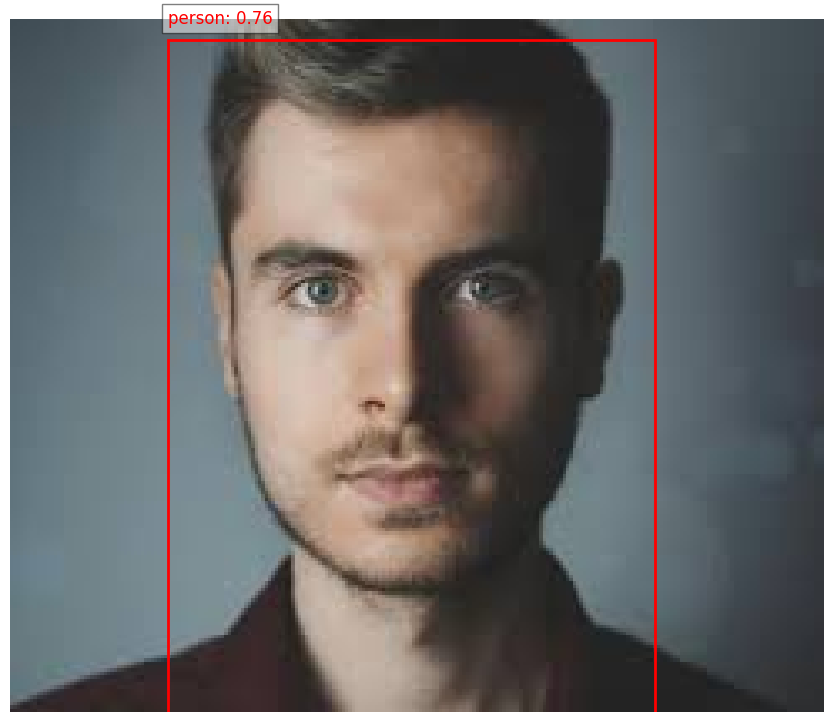

In [ ]:
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 1. Load the saved model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_save_path = "/content/drive/MyDrive/detection_model/custom_fasterrcnn_resnet50.pth"  # Update this path

# Load the entire model
model = torch.load(model_save_path, map_location=device)
model.to(device)
model.eval()  # Set the model to evaluation mode

# 2. Preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Load image and ensure it's RGB
    transform = ToTensor()
    tensor_image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
    return image, tensor_image

# 3. Perform inference
def predict_single_image(image_path, model, threshold=0.5):
    image, tensor_image = preprocess_image(image_path)

    with torch.no_grad():
        predictions = model(tensor_image)  # Get predictions
        pred_boxes = predictions[0]['boxes'].cpu().numpy()  # Bounding boxes
        pred_scores = predictions[0]['scores'].cpu().numpy()  # Confidence scores
        pred_labels = predictions[0]['labels'].cpu().numpy()  # Class labels

    # Filter predictions based on the threshold
    valid_indices = pred_scores > threshold
    pred_boxes = pred_boxes[valid_indices]
    pred_scores = pred_scores[valid_indices]
    pred_labels = pred_labels[valid_indices]

    return image, pred_boxes, pred_scores, pred_labels

# 4. Visualize predictions
def visualize_predictions(image, boxes, scores, labels, class_names=None):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        label_text = f"{class_names[label] if class_names else label}: {score:.2f}"
        ax.text(xmin, ymin - 5, label_text, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()

# 5. Run the test
image_path = "/content/person2.jpeg"  # Provide the path to your image
image, pred_boxes, pred_scores, pred_labels = predict_single_image(image_path, model, threshold=0.5)

# Optional: COCO class names
coco_classes = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
    'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird',
    'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
    'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
    'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
    'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv',
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink',
    'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Visualize predictions
visualize_predictions(image, pred_boxes, pred_scores, pred_labels, class_names=coco_classes)


Evaluating:   0%|          | 6/2500 [00:00<02:29, 16.72it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   1%|          | 13/2500 [00:00<02:12, 18.80it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   1%|          | 25/2500 [00:01<02:08, 19.22it/s]

Skipping image with no ground truths or predictions.


Evaluating:   1%|▏         | 33/2500 [00:01<02:04, 19.83it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   2%|▏         | 40/2500 [00:02<02:03, 19.98it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   3%|▎         | 73/2500 [00:03<02:01, 20.00it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   3%|▎         | 77/2500 [00:03<02:07, 18.96it/s]

Skipping image with no ground truths or predictions.


Evaluating:   3%|▎         | 86/2500 [00:04<02:08, 18.77it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   4%|▎         | 93/2500 [00:04<02:05, 19.26it/s]

Skipping image with no ground truths or predictions.


Evaluating:   4%|▍         | 102/2500 [00:05<02:01, 19.70it/s]

Skipping image with no ground truths or predictions.


Evaluating:   4%|▍         | 106/2500 [00:05<02:06, 18.88it/s]

Skipping image with no ground truths or predictions.


Evaluating:   4%|▍         | 112/2500 [00:05<02:00, 19.81it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   5%|▍         | 117/2500 [00:06<01:59, 19.95it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   5%|▌         | 125/2500 [00:06<02:04, 19.14it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 250 due to no valid annotations.


Evaluating:   5%|▌         | 137/2500 [00:07<01:54, 20.59it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   6%|▌         | 145/2500 [00:07<02:02, 19.25it/s]

Skipping image with no ground truths or predictions.


Evaluating:   6%|▌         | 152/2500 [00:07<02:01, 19.32it/s]

Skipping image with no ground truths or predictions.


Evaluating:   6%|▋         | 159/2500 [00:08<02:02, 19.11it/s]

Skipping image with no ground truths or predictions.


Evaluating:   7%|▋         | 165/2500 [00:08<02:06, 18.46it/s]

Skipping image with no ground truths or predictions.


Evaluating:   7%|▋         | 169/2500 [00:08<02:06, 18.42it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   8%|▊         | 188/2500 [00:09<01:55, 20.02it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 370 due to no valid annotations.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   8%|▊         | 194/2500 [00:10<01:52, 20.57it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image at index 384 due to no valid annotations.


Evaluating:   8%|▊         | 200/2500 [00:10<01:55, 19.93it/s]

Skipping image with no ground truths or predictions.


Evaluating:   8%|▊         | 206/2500 [00:10<01:54, 20.08it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   9%|▊         | 218/2500 [00:11<01:50, 20.73it/s]

Skipping image at index 431 due to no valid annotations.


Evaluating:   9%|▉         | 224/2500 [00:11<01:49, 20.69it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   9%|▉         | 230/2500 [00:11<01:53, 20.08it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   9%|▉         | 233/2500 [00:11<01:55, 19.58it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:   9%|▉         | 237/2500 [00:12<01:57, 19.30it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  10%|▉         | 243/2500 [00:12<01:53, 19.95it/s]

Skipping image with no ground truths or predictions.


Evaluating:  10%|█         | 250/2500 [00:12<01:52, 20.03it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  10%|█         | 259/2500 [00:13<01:46, 21.08it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 516 due to no valid annotations.


Evaluating:  11%|█         | 271/2500 [00:13<01:51, 20.00it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  11%|█▏        | 283/2500 [00:14<01:48, 20.36it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 566 due to no valid annotations.


Evaluating:  12%|█▏        | 289/2500 [00:14<01:47, 20.56it/s]

Skipping image with no ground truths or predictions.


Evaluating:  12%|█▏        | 292/2500 [00:14<01:48, 20.30it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  12%|█▏        | 297/2500 [00:15<01:58, 18.66it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  12%|█▏        | 301/2500 [00:15<01:58, 18.54it/s]

Skipping image with no ground truths or predictions.


Evaluating:  13%|█▎        | 317/2500 [00:16<01:55, 18.91it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  13%|█▎        | 325/2500 [00:16<01:49, 19.80it/s]

Skipping image with no ground truths or predictions.


Evaluating:  13%|█▎        | 337/2500 [00:17<01:52, 19.31it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  14%|█▍        | 344/2500 [00:17<01:52, 19.18it/s]

Skipping image with no ground truths or predictions.


Evaluating:  14%|█▍        | 351/2500 [00:18<01:50, 19.40it/s]

Skipping image with no ground truths or predictions.


Evaluating:  14%|█▍        | 355/2500 [00:18<01:52, 19.07it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  15%|█▍        | 363/2500 [00:18<01:54, 18.65it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  15%|█▍        | 372/2500 [00:19<01:49, 19.41it/s]

Skipping image with no ground truths or predictions.


Evaluating:  15%|█▌        | 378/2500 [00:19<01:52, 18.85it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  15%|█▌        | 386/2500 [00:19<01:54, 18.54it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  16%|█▌        | 390/2500 [00:20<01:52, 18.71it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  16%|█▌        | 397/2500 [00:20<01:50, 19.02it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  16%|█▌        | 399/2500 [00:20<01:50, 19.01it/s]

Skipping image with no ground truths or predictions.


Evaluating:  16%|█▋        | 409/2500 [00:21<01:46, 19.65it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  17%|█▋        | 415/2500 [00:21<01:50, 18.93it/s]

Skipping image with no ground truths or predictions.


Evaluating:  17%|█▋        | 423/2500 [00:21<01:46, 19.47it/s]

Skipping image at index 838 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  17%|█▋        | 427/2500 [00:22<01:46, 19.52it/s]

Skipping image with no ground truths or predictions.


Evaluating:  17%|█▋        | 435/2500 [00:22<01:41, 20.44it/s]

Skipping image at index 862 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  18%|█▊        | 447/2500 [00:23<01:44, 19.65it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  18%|█▊        | 453/2500 [00:23<01:45, 19.48it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  18%|█▊        | 458/2500 [00:23<01:43, 19.75it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  19%|█▊        | 464/2500 [00:23<01:45, 19.24it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  19%|█▉        | 471/2500 [00:24<01:46, 19.14it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  19%|█▉        | 483/2500 [00:24<01:44, 19.36it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  20%|█▉        | 490/2500 [00:25<01:42, 19.69it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  20%|█▉        | 495/2500 [00:25<01:42, 19.52it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  20%|██        | 506/2500 [00:26<01:40, 19.81it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  20%|██        | 509/2500 [00:26<01:36, 20.53it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 1015 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  21%|██        | 515/2500 [00:26<01:39, 20.00it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  21%|██        | 526/2500 [00:27<01:39, 19.82it/s]

Skipping image with no ground truths or predictions.


Evaluating:  21%|██▏       | 533/2500 [00:27<01:39, 19.82it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image at index 1066 due to no valid annotations.


Evaluating:  22%|██▏       | 547/2500 [00:28<01:37, 20.12it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  22%|██▏       | 553/2500 [00:28<01:41, 19.24it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  22%|██▏       | 559/2500 [00:28<01:40, 19.35it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  23%|██▎       | 565/2500 [00:29<01:39, 19.35it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  23%|██▎       | 579/2500 [00:29<01:41, 18.94it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  23%|██▎       | 583/2500 [00:29<01:41, 18.86it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  24%|██▎       | 591/2500 [00:30<01:37, 19.57it/s]

Skipping image with no ground truths or predictions.


Evaluating:  24%|██▍       | 597/2500 [00:30<01:39, 19.08it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  24%|██▍       | 606/2500 [00:31<01:38, 19.15it/s]

Skipping image with no ground truths or predictions.


Evaluating:  24%|██▍       | 612/2500 [00:31<01:39, 19.02it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  25%|██▍       | 616/2500 [00:31<01:39, 18.96it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  25%|██▍       | 623/2500 [00:32<01:40, 18.74it/s]

Skipping image with no ground truths or predictions.


Evaluating:  25%|██▌       | 632/2500 [00:32<01:35, 19.48it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  26%|██▌       | 638/2500 [00:32<01:34, 19.63it/s]

Skipping image with no ground truths or predictions.


Evaluating:  26%|██▌       | 647/2500 [00:33<01:37, 19.05it/s]

Skipping image with no ground truths or predictions.


Evaluating:  26%|██▌       | 653/2500 [00:33<01:36, 19.22it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  26%|██▋       | 658/2500 [00:33<01:34, 19.53it/s]

Skipping image with no ground truths or predictions.


Evaluating:  27%|██▋       | 664/2500 [00:34<01:31, 19.97it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  27%|██▋       | 673/2500 [00:34<01:34, 19.33it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  27%|██▋       | 681/2500 [00:35<01:31, 19.93it/s]

Skipping image with no ground truths or predictions.


Evaluating:  27%|██▋       | 687/2500 [00:35<01:30, 20.08it/s]

Skipping image with no ground truths or predictions.


Evaluating:  28%|██▊       | 697/2500 [00:35<01:35, 18.80it/s]

Skipping image with no ground truths or predictions.


Evaluating:  28%|██▊       | 705/2500 [00:36<01:34, 18.95it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  29%|██▊       | 715/2500 [00:36<01:35, 18.61it/s]

Skipping image with no ground truths or predictions.


Evaluating:  29%|██▉       | 722/2500 [00:37<01:30, 19.56it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  29%|██▉       | 724/2500 [00:37<01:32, 19.20it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  29%|██▉       | 729/2500 [00:37<01:31, 19.29it/s]

Skipping image with no ground truths or predictions.


Evaluating:  30%|██▉       | 743/2500 [00:38<01:32, 18.92it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  30%|███       | 750/2500 [00:38<01:31, 19.13it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 1501 due to no valid annotations.


Evaluating:  30%|███       | 759/2500 [00:39<01:28, 19.66it/s]

Skipping image with no ground truths or predictions.


Evaluating:  31%|███       | 766/2500 [00:39<01:26, 19.97it/s]

Skipping image at index 1524 due to no valid annotations.


Evaluating:  31%|███       | 770/2500 [00:39<01:30, 19.21it/s]

Skipping image with no ground truths or predictions.


Evaluating:  31%|███       | 774/2500 [00:39<01:32, 18.75it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  31%|███       | 778/2500 [00:40<01:33, 18.51it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  31%|███▏      | 785/2500 [00:40<01:26, 19.87it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  32%|███▏      | 793/2500 [00:40<01:27, 19.46it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  32%|███▏      | 799/2500 [00:41<01:28, 19.24it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  32%|███▏      | 806/2500 [00:41<01:25, 19.77it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  33%|███▎      | 820/2500 [00:42<01:30, 18.54it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  33%|███▎      | 825/2500 [00:42<01:28, 18.95it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  33%|███▎      | 830/2500 [00:42<01:26, 19.34it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  33%|███▎      | 835/2500 [00:43<01:24, 19.71it/s]

Skipping image with no ground truths or predictions.


Evaluating:  34%|███▍      | 847/2500 [00:43<01:27, 18.81it/s]

Skipping image with no ground truths or predictions.


Evaluating:  34%|███▍      | 853/2500 [00:44<01:28, 18.61it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  34%|███▍      | 858/2500 [00:44<01:23, 19.62it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  35%|███▍      | 867/2500 [00:44<01:25, 19.01it/s]

Skipping image with no ground truths or predictions.


Evaluating:  35%|███▍      | 872/2500 [00:45<01:22, 19.64it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 1737 due to no valid annotations.


Evaluating:  35%|███▌      | 878/2500 [00:45<01:17, 20.86it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 1749 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  35%|███▌      | 881/2500 [00:45<01:18, 20.68it/s]

Skipping image with no ground truths or predictions.


Evaluating:  36%|███▌      | 890/2500 [00:45<01:21, 19.87it/s]

Skipping image with no ground truths or predictions.


Evaluating:  36%|███▌      | 898/2500 [00:46<01:21, 19.71it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  36%|███▌      | 906/2500 [00:46<01:19, 20.04it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  36%|███▋      | 909/2500 [00:46<01:19, 20.09it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  37%|███▋      | 915/2500 [00:47<01:19, 20.03it/s]

Skipping image with no ground truths or predictions.


Evaluating:  37%|███▋      | 920/2500 [00:47<01:20, 19.71it/s]

Skipping image with no ground truths or predictions.


Evaluating:  37%|███▋      | 930/2500 [00:47<01:20, 19.62it/s]

Skipping image with no ground truths or predictions.


Evaluating:  38%|███▊      | 943/2500 [00:48<01:21, 19.01it/s]

Skipping image with no ground truths or predictions.


Evaluating:  38%|███▊      | 947/2500 [00:48<01:22, 18.85it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  38%|███▊      | 953/2500 [00:49<01:28, 17.51it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  38%|███▊      | 957/2500 [00:49<01:25, 18.02it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  38%|███▊      | 960/2500 [00:49<01:22, 18.77it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  39%|███▊      | 967/2500 [00:49<01:21, 18.90it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  39%|███▉      | 973/2500 [00:50<01:20, 18.99it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  39%|███▉      | 982/2500 [00:50<01:15, 20.24it/s]

Skipping image at index 1961 due to no valid annotations.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  40%|███▉      | 988/2500 [00:50<01:15, 19.92it/s]

Skipping image with no ground truths or predictions.


Evaluating:  40%|███▉      | 996/2500 [00:51<01:14, 20.26it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image at index 1988 due to no valid annotations.


Evaluating:  40%|████      | 1004/2500 [00:51<01:16, 19.46it/s]

Skipping image with no ground truths or predictions.


Evaluating:  41%|████      | 1013/2500 [00:52<01:17, 19.21it/s]

Skipping image with no ground truths or predictions.


Evaluating:  41%|████      | 1018/2500 [00:52<01:15, 19.56it/s]

Skipping image with no ground truths or predictions.


Evaluating:  41%|████      | 1024/2500 [00:52<01:16, 19.18it/s]

Skipping image with no ground truths or predictions.


Evaluating:  41%|████      | 1027/2500 [00:52<01:16, 19.23it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  42%|████▏     | 1038/2500 [00:53<01:16, 19.23it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  42%|████▏     | 1046/2500 [00:54<01:22, 17.53it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  42%|████▏     | 1052/2500 [00:54<01:14, 19.56it/s]

Skipping image at index 2098 due to no valid annotations.


Evaluating:  42%|████▏     | 1060/2500 [00:54<01:16, 18.87it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  43%|████▎     | 1070/2500 [00:55<01:14, 19.25it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  43%|████▎     | 1085/2500 [00:56<01:13, 19.32it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  44%|████▍     | 1094/2500 [00:56<01:12, 19.44it/s]

Skipping image with no ground truths or predictions.


Evaluating:  44%|████▍     | 1096/2500 [00:56<01:14, 18.95it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  44%|████▍     | 1108/2500 [00:57<01:10, 19.80it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  45%|████▍     | 1114/2500 [00:57<01:12, 19.06it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  45%|████▍     | 1124/2500 [00:58<01:12, 18.86it/s]

Skipping image with no ground truths or predictions.


Evaluating:  45%|████▌     | 1129/2500 [00:58<01:10, 19.50it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 2253 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  45%|████▌     | 1136/2500 [00:58<01:10, 19.45it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 2265 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  46%|████▌     | 1140/2500 [00:58<01:10, 19.21it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  46%|████▌     | 1144/2500 [00:59<01:13, 18.48it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  46%|████▌     | 1148/2500 [00:59<01:11, 18.78it/s]

Skipping image with no ground truths or predictions.


Evaluating:  46%|████▋     | 1159/2500 [00:59<01:07, 20.00it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 2315 due to no valid annotations.
Skipping image with no ground truths or predictions.
Skipping image at index 2321 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  47%|████▋     | 1165/2500 [01:00<01:04, 20.60it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  47%|████▋     | 1171/2500 [01:00<01:04, 20.60it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 2336 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  47%|████▋     | 1180/2500 [01:00<01:06, 19.79it/s]

Skipping image with no ground truths or predictions.


Evaluating:  47%|████▋     | 1184/2500 [01:01<01:08, 19.21it/s]

Skipping image with no ground truths or predictions.


Evaluating:  48%|████▊     | 1199/2500 [01:01<01:05, 19.99it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 2397 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  48%|████▊     | 1206/2500 [01:02<01:05, 19.68it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  49%|████▉     | 1223/2500 [01:03<01:06, 19.13it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  49%|████▉     | 1236/2500 [01:03<01:05, 19.35it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  50%|████▉     | 1246/2500 [01:04<01:05, 19.06it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  50%|████▉     | 1248/2500 [01:04<01:05, 19.03it/s]

Skipping image with no ground truths or predictions.


Evaluating:  50%|█████     | 1253/2500 [01:04<01:04, 19.27it/s]

Skipping image with no ground truths or predictions.


Evaluating:  50%|█████     | 1261/2500 [01:05<01:07, 18.23it/s]

Skipping image with no ground truths or predictions.


Evaluating:  51%|█████     | 1269/2500 [01:05<01:06, 18.58it/s]

Skipping image with no ground truths or predictions.


Evaluating:  52%|█████▏    | 1295/2500 [01:06<01:01, 19.72it/s]

Skipping image with no ground truths or predictions.


Evaluating:  52%|█████▏    | 1300/2500 [01:07<01:00, 19.90it/s]

Skipping image with no ground truths or predictions.


Evaluating:  52%|█████▏    | 1307/2500 [01:07<01:01, 19.39it/s]

Skipping image with no ground truths or predictions.


Evaluating:  53%|█████▎    | 1320/2500 [01:08<01:02, 19.02it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  53%|█████▎    | 1333/2500 [01:08<00:57, 20.37it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 2663 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  53%|█████▎    | 1336/2500 [01:09<00:59, 19.49it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  54%|█████▎    | 1343/2500 [01:09<00:59, 19.41it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image at index 2687 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  54%|█████▍    | 1349/2500 [01:09<00:56, 20.20it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  54%|█████▍    | 1352/2500 [01:09<01:00, 18.84it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  54%|█████▍    | 1358/2500 [01:10<00:55, 20.43it/s]

Skipping image at index 2713 due to no valid annotations.


Evaluating:  55%|█████▍    | 1364/2500 [01:10<01:02, 18.23it/s]

Skipping image with no ground truths or predictions.


Evaluating:  55%|█████▍    | 1368/2500 [01:10<01:02, 18.20it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  55%|█████▍    | 1374/2500 [01:11<00:57, 19.61it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  55%|█████▌    | 1380/2500 [01:11<00:56, 19.98it/s]

Skipping image with no ground truths or predictions.


Evaluating:  55%|█████▌    | 1386/2500 [01:11<00:54, 20.52it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 2769 due to no valid annotations.


Evaluating:  56%|█████▌    | 1392/2500 [01:11<00:55, 20.04it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  56%|█████▌    | 1395/2500 [01:12<00:56, 19.55it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  56%|█████▌    | 1399/2500 [01:12<00:57, 19.31it/s]

Skipping image with no ground truths or predictions.


Evaluating:  56%|█████▌    | 1404/2500 [01:12<00:56, 19.38it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  56%|█████▋    | 1409/2500 [01:12<00:55, 19.81it/s]

Skipping image with no ground truths or predictions.


Evaluating:  57%|█████▋    | 1419/2500 [01:13<00:54, 19.71it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  57%|█████▋    | 1424/2500 [01:13<00:54, 19.75it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  57%|█████▋    | 1430/2500 [01:13<00:51, 20.91it/s]

Skipping image at index 2856 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  57%|█████▋    | 1436/2500 [01:14<00:52, 20.26it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  58%|█████▊    | 1441/2500 [01:14<00:53, 19.65it/s]

Skipping image with no ground truths or predictions.


Evaluating:  58%|█████▊    | 1446/2500 [01:14<00:53, 19.68it/s]

Skipping image with no ground truths or predictions.


Evaluating:  58%|█████▊    | 1452/2500 [01:14<00:53, 19.62it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  58%|█████▊    | 1458/2500 [01:15<00:56, 18.59it/s]

Skipping image with no ground truths or predictions.


Evaluating:  59%|█████▉    | 1475/2500 [01:16<00:52, 19.37it/s]

Skipping image with no ground truths or predictions.


Evaluating:  59%|█████▉    | 1480/2500 [01:16<00:52, 19.61it/s]

Skipping image with no ground truths or predictions.


Evaluating:  60%|█████▉    | 1488/2500 [01:16<00:49, 20.32it/s]

Skipping image at index 2970 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  60%|█████▉    | 1497/2500 [01:17<00:52, 19.28it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  60%|██████    | 1501/2500 [01:17<00:51, 19.47it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  60%|██████    | 1506/2500 [01:17<00:51, 19.28it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  61%|██████    | 1513/2500 [01:18<00:51, 19.26it/s]

Skipping image with no ground truths or predictions.


Evaluating:  61%|██████    | 1518/2500 [01:18<00:50, 19.40it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  61%|██████    | 1522/2500 [01:18<00:51, 18.95it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  61%|██████    | 1528/2500 [01:18<00:51, 18.72it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  61%|██████▏   | 1532/2500 [01:19<00:52, 18.40it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  62%|██████▏   | 1539/2500 [01:19<00:51, 18.65it/s]

Skipping image with no ground truths or predictions.


Evaluating:  62%|██████▏   | 1545/2500 [01:19<00:51, 18.46it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  62%|██████▏   | 1551/2500 [01:20<00:51, 18.44it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  62%|██████▏   | 1555/2500 [01:20<00:51, 18.28it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  62%|██████▏   | 1561/2500 [01:20<00:51, 18.27it/s]

Skipping image with no ground truths or predictions.


Evaluating:  63%|██████▎   | 1567/2500 [01:20<00:49, 18.82it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  63%|██████▎   | 1571/2500 [01:21<00:50, 18.30it/s]

Skipping image with no ground truths or predictions.


Evaluating:  63%|██████▎   | 1579/2500 [01:21<00:52, 17.54it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  63%|██████▎   | 1586/2500 [01:22<00:49, 18.47it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  64%|██████▍   | 1597/2500 [01:22<00:48, 18.73it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  64%|██████▍   | 1604/2500 [01:22<00:47, 18.86it/s]

Skipping image with no ground truths or predictions.


Evaluating:  64%|██████▍   | 1611/2500 [01:23<00:44, 19.90it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 3216 due to no valid annotations.


Evaluating:  65%|██████▍   | 1617/2500 [01:23<00:46, 19.03it/s]

Skipping image with no ground truths or predictions.


Evaluating:  65%|██████▍   | 1624/2500 [01:24<00:45, 19.45it/s]

Skipping image at index 3242 due to no valid annotations.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  65%|██████▌   | 1630/2500 [01:24<00:46, 18.70it/s]

Skipping image with no ground truths or predictions.


Evaluating:  65%|██████▌   | 1636/2500 [01:24<00:46, 18.60it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  66%|██████▌   | 1640/2500 [01:24<00:46, 18.62it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  66%|██████▌   | 1651/2500 [01:25<00:45, 18.51it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  66%|██████▋   | 1659/2500 [01:25<00:42, 19.90it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 3314 due to no valid annotations.


Evaluating:  67%|██████▋   | 1664/2500 [01:26<00:42, 19.86it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  67%|██████▋   | 1676/2500 [01:26<00:40, 20.30it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  67%|██████▋   | 1682/2500 [01:27<00:40, 19.98it/s]

Skipping image with no ground truths or predictions.


Evaluating:  67%|██████▋   | 1687/2500 [01:27<00:41, 19.70it/s]

Skipping image with no ground truths or predictions.


Evaluating:  68%|██████▊   | 1698/2500 [01:27<00:41, 19.44it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  68%|██████▊   | 1704/2500 [01:28<00:41, 19.21it/s]

Skipping image with no ground truths or predictions.


Evaluating:  68%|██████▊   | 1710/2500 [01:28<00:41, 18.96it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  69%|██████▊   | 1716/2500 [01:28<00:39, 19.78it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  69%|██████▉   | 1722/2500 [01:29<00:39, 19.62it/s]

Skipping image with no ground truths or predictions.


Evaluating:  69%|██████▉   | 1725/2500 [01:29<00:39, 19.82it/s]

Skipping image with no ground truths or predictions.


Evaluating:  69%|██████▉   | 1733/2500 [01:29<00:39, 19.36it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image at index 3466 due to no valid annotations.


Evaluating:  69%|██████▉   | 1736/2500 [01:29<00:37, 20.26it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  70%|██████▉   | 1743/2500 [01:30<00:38, 19.77it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  70%|██████▉   | 1749/2500 [01:30<00:37, 20.07it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 3492 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  70%|███████   | 1755/2500 [01:30<00:37, 19.69it/s]

Skipping image with no ground truths or predictions.


Evaluating:  70%|███████   | 1760/2500 [01:30<00:38, 19.39it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  71%|███████   | 1766/2500 [01:31<00:36, 19.85it/s]

Skipping image with no ground truths or predictions.


Evaluating:  71%|███████   | 1772/2500 [01:31<00:38, 18.97it/s]

Skipping image with no ground truths or predictions.


Evaluating:  71%|███████   | 1781/2500 [01:32<00:36, 19.63it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  71%|███████▏  | 1785/2500 [01:32<00:37, 19.30it/s]

Skipping image with no ground truths or predictions.


Evaluating:  72%|███████▏  | 1791/2500 [01:32<00:38, 18.40it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  72%|███████▏  | 1799/2500 [01:33<00:37, 18.66it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  72%|███████▏  | 1803/2500 [01:33<00:36, 19.08it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  72%|███████▏  | 1812/2500 [01:33<00:35, 19.33it/s]

Skipping image with no ground truths or predictions.


Evaluating:  73%|███████▎  | 1817/2500 [01:33<00:35, 19.37it/s]

Skipping image with no ground truths or predictions.


Evaluating:  73%|███████▎  | 1835/2500 [01:34<00:33, 19.79it/s]

Skipping image with no ground truths or predictions.


Evaluating:  74%|███████▍  | 1854/2500 [01:35<00:33, 19.41it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  75%|███████▍  | 1863/2500 [01:36<00:31, 20.20it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  75%|███████▍  | 1866/2500 [01:36<00:31, 20.38it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  75%|███████▍  | 1872/2500 [01:36<00:31, 20.13it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  75%|███████▌  | 1880/2500 [01:37<00:31, 19.64it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  75%|███████▌  | 1884/2500 [01:37<00:32, 18.89it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  76%|███████▌  | 1900/2500 [01:38<00:31, 19.24it/s]

Skipping image with no ground truths or predictions.


Evaluating:  76%|███████▋  | 1907/2500 [01:38<00:30, 19.15it/s]

Skipping image with no ground truths or predictions.


Evaluating:  76%|███████▋  | 1912/2500 [01:38<00:30, 19.26it/s]

Skipping image with no ground truths or predictions.


Evaluating:  77%|███████▋  | 1916/2500 [01:39<00:30, 19.22it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  77%|███████▋  | 1920/2500 [01:39<00:30, 18.78it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  77%|███████▋  | 1925/2500 [01:39<00:29, 19.63it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 3851 due to no valid annotations.


Evaluating:  77%|███████▋  | 1934/2500 [01:39<00:27, 20.69it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  78%|███████▊  | 1946/2500 [01:40<00:28, 19.72it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  78%|███████▊  | 1950/2500 [01:40<00:28, 19.26it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  78%|███████▊  | 1954/2500 [01:40<00:28, 19.24it/s]

Skipping image with no ground truths or predictions.


Evaluating:  78%|███████▊  | 1959/2500 [01:41<00:27, 19.36it/s]

Skipping image with no ground truths or predictions.


Evaluating:  79%|███████▊  | 1963/2500 [01:41<00:27, 19.48it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  79%|███████▉  | 1971/2500 [01:41<00:26, 19.81it/s]

Skipping image with no ground truths or predictions.


Evaluating:  79%|███████▉  | 1976/2500 [01:42<00:26, 19.71it/s]

Skipping image with no ground truths or predictions.


Evaluating:  79%|███████▉  | 1981/2500 [01:42<00:25, 20.33it/s]

Skipping image at index 3956 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  80%|███████▉  | 1989/2500 [01:42<00:26, 19.04it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  80%|███████▉  | 1993/2500 [01:42<00:26, 19.20it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 3986 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  80%|████████  | 2012/2500 [01:43<00:25, 18.94it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  81%|████████  | 2023/2500 [01:44<00:25, 18.99it/s]

Skipping image with no ground truths or predictions.


Evaluating:  81%|████████  | 2028/2500 [01:44<00:24, 19.32it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  81%|████████▏ | 2034/2500 [01:45<00:23, 20.10it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  82%|████████▏ | 2038/2500 [01:45<00:24, 19.20it/s]

Skipping image with no ground truths or predictions.


Evaluating:  82%|████████▏ | 2044/2500 [01:45<00:23, 19.07it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  82%|████████▏ | 2054/2500 [01:46<00:22, 19.74it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  82%|████████▏ | 2061/2500 [01:46<00:22, 19.64it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  83%|████████▎ | 2066/2500 [01:46<00:21, 20.31it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 4127 due to no valid annotations.
Skipping image with no ground truths or predictions.
Skipping image at index 4133 due to no valid annotations.


Evaluating:  83%|████████▎ | 2069/2500 [01:46<00:20, 20.56it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  83%|████████▎ | 2075/2500 [01:47<00:21, 19.97it/s]

Skipping image with no ground truths or predictions.


Evaluating:  83%|████████▎ | 2081/2500 [01:47<00:21, 19.64it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  83%|████████▎ | 2087/2500 [01:47<00:20, 20.13it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 4169 due to no valid annotations.


Evaluating:  84%|████████▍ | 2102/2500 [01:48<00:20, 19.23it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  84%|████████▍ | 2106/2500 [01:48<00:21, 18.62it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  84%|████████▍ | 2111/2500 [01:49<00:20, 19.01it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  85%|████████▍ | 2116/2500 [01:49<00:19, 19.70it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  85%|████████▌ | 2126/2500 [01:49<00:19, 19.25it/s]

Skipping image with no ground truths or predictions.


Evaluating:  85%|████████▌ | 2131/2500 [01:50<00:19, 19.30it/s]

Skipping image with no ground truths or predictions.


Evaluating:  85%|████████▌ | 2137/2500 [01:50<00:18, 19.24it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  86%|████████▌ | 2152/2500 [01:51<00:18, 18.86it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  86%|████████▋ | 2157/2500 [01:51<00:17, 19.59it/s]

Skipping image with no ground truths or predictions.


Evaluating:  87%|████████▋ | 2170/2500 [01:52<00:16, 19.53it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  87%|████████▋ | 2176/2500 [01:52<00:15, 20.81it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 4344 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  87%|████████▋ | 2185/2500 [01:52<00:16, 19.49it/s]

Skipping image with no ground truths or predictions.


Evaluating:  88%|████████▊ | 2198/2500 [01:53<00:15, 18.88it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  89%|████████▊ | 2213/2500 [01:54<00:15, 19.10it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  89%|████████▉ | 2220/2500 [01:54<00:13, 20.36it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image at index 4439 due to no valid annotations.


Evaluating:  89%|████████▉ | 2225/2500 [01:54<00:13, 19.83it/s]

Skipping image with no ground truths or predictions.


Evaluating:  90%|████████▉ | 2240/2500 [01:55<00:13, 19.10it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  90%|████████▉ | 2246/2500 [01:55<00:12, 19.54it/s]

Skipping image with no ground truths or predictions.


Evaluating:  90%|█████████ | 2251/2500 [01:56<00:12, 19.66it/s]

Skipping image with no ground truths or predictions.


Evaluating:  90%|█████████ | 2257/2500 [01:56<00:12, 19.19it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  91%|█████████ | 2265/2500 [01:56<00:11, 19.90it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  91%|█████████ | 2269/2500 [01:57<00:11, 19.55it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  91%|█████████ | 2274/2500 [01:57<00:11, 19.97it/s]

Skipping image with no ground truths or predictions.


Evaluating:  91%|█████████ | 2278/2500 [01:57<00:11, 18.94it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 4557 due to no valid annotations.


Evaluating:  91%|█████████▏| 2286/2500 [01:58<00:10, 19.89it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  92%|█████████▏| 2291/2500 [01:58<00:10, 19.81it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  92%|█████████▏| 2297/2500 [01:58<00:10, 19.61it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  92%|█████████▏| 2305/2500 [01:58<00:09, 20.25it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  93%|█████████▎| 2314/2500 [01:59<00:09, 20.24it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 4623 due to no valid annotations.


Evaluating:  93%|█████████▎| 2325/2500 [01:59<00:08, 19.67it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  93%|█████████▎| 2331/2500 [02:00<00:08, 20.88it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image at index 4659 due to no valid annotations.
Skipping image with no ground truths or predictions.


Evaluating:  94%|█████████▎| 2343/2500 [02:00<00:07, 20.32it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  94%|█████████▍| 2351/2500 [02:01<00:07, 19.67it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  94%|█████████▍| 2356/2500 [02:01<00:07, 19.44it/s]

Skipping image with no ground truths or predictions.


Evaluating:  95%|█████████▍| 2363/2500 [02:01<00:07, 19.46it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  95%|█████████▍| 2367/2500 [02:02<00:07, 18.38it/s]

Skipping image with no ground truths or predictions.
Skipping image at index 4731 due to no valid annotations.


Evaluating:  95%|█████████▍| 2371/2500 [02:02<00:06, 18.56it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  95%|█████████▍| 2374/2500 [02:02<00:06, 19.24it/s]

Skipping image with no ground truths or predictions.


Evaluating:  95%|█████████▌| 2386/2500 [02:03<00:05, 20.02it/s]

Skipping image with no ground truths or predictions.


Evaluating:  96%|█████████▌| 2393/2500 [02:03<00:05, 19.89it/s]

Skipping image at index 4779 due to no valid annotations.


Evaluating:  96%|█████████▌| 2398/2500 [02:03<00:05, 19.73it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  96%|█████████▌| 2405/2500 [02:04<00:04, 20.36it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image at index 4809 due to no valid annotations.


Evaluating:  96%|█████████▋| 2411/2500 [02:04<00:04, 20.41it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  97%|█████████▋| 2416/2500 [02:04<00:04, 19.96it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  97%|█████████▋| 2426/2500 [02:05<00:03, 18.98it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  97%|█████████▋| 2436/2500 [02:05<00:03, 19.54it/s]

Skipping image with no ground truths or predictions.


Evaluating:  98%|█████████▊| 2439/2500 [02:05<00:03, 19.48it/s]

Skipping image with no ground truths or predictions.


Evaluating:  98%|█████████▊| 2452/2500 [02:06<00:02, 19.22it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  98%|█████████▊| 2457/2500 [02:06<00:02, 19.25it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  99%|█████████▊| 2463/2500 [02:07<00:01, 19.26it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  99%|█████████▊| 2466/2500 [02:07<00:01, 19.48it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  99%|█████████▉| 2474/2500 [02:07<00:01, 19.98it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating:  99%|█████████▉| 2482/2500 [02:08<00:00, 19.08it/s]

Skipping image with no ground truths or predictions.


Evaluating:  99%|█████████▉| 2486/2500 [02:08<00:00, 19.30it/s]

Skipping image with no ground truths or predictions.


Evaluating: 100%|█████████▉| 2490/2500 [02:08<00:00, 19.29it/s]

Skipping image with no ground truths or predictions.


Evaluating: 100%|█████████▉| 2495/2500 [02:08<00:00, 19.60it/s]

Skipping image with no ground truths or predictions.
Skipping image with no ground truths or predictions.


Evaluating: 100%|██████████| 2500/2500 [02:08<00:00, 19.39it/s]

Skipping image with no ground truths or predictions.
Precision: 0.6447
Recall: 0.2893
F1 Score: 0.3994
Mean IoU: 0.7398


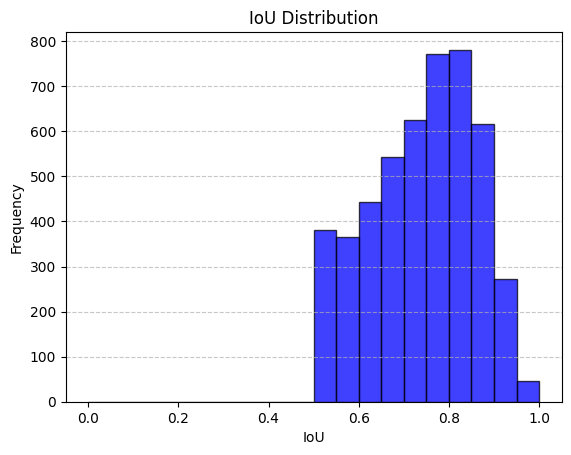

In [ ]:
from collections import OrderedDict
import torch
from torchvision.ops import box_iou
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Initialize counters for metrics
all_true_positives = 0
all_false_positives = 0
all_false_negatives = 0
iou_scores = []

# Process validation dataset
iou_threshold = 0.5
for images, targets in tqdm(val_loader, desc="Evaluating"):
    if len(images) == 0 or len(targets) == 0:
        continue  # Skip empty or invalid batches

    images = [img.to(device) for img in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():
        predictions = model(images)

    # Check predictions structure
    if predictions and len(predictions) > 0 and 'boxes' in predictions[0]:
        pred_boxes = predictions[0]['boxes'].cpu().numpy()
        pred_scores = predictions[0]['scores'].cpu().numpy()
        pred_labels = predictions[0]['labels'].cpu().numpy()
    else:
        print("Skipping image with no valid predictions.")
        continue

    # Filter predictions based on confidence threshold
    confidence_threshold = 0.5
    valid_indices = pred_scores > confidence_threshold
    pred_boxes = pred_boxes[valid_indices]
    pred_labels = pred_labels[valid_indices]

    # Extract ground truth boxes and labels
    ground_truth_boxes = targets[0]['boxes'].cpu().numpy()
    ground_truth_labels = targets[0]['labels'].cpu().numpy()

    # Skip images with no ground truths or predictions
    if len(ground_truth_boxes) == 0 or len(pred_boxes) == 0:
        print("Skipping image with no ground truths or predictions.")
        continue

    # Compute IoU for the ground truth and predictions
    iou_matrix = box_iou(torch.tensor(pred_boxes), torch.tensor(ground_truth_boxes)).numpy()

    # Calculate true positives, false positives, and false negatives
    tp = 0
    fp = 0
    fn = 0

    for pred_idx, ious in enumerate(iou_matrix):
        max_iou = max(ious)
        if max_iou >= iou_threshold:
            tp += 1  # True positive
        else:
            fp += 1  # False positive

    fn = len(ground_truth_boxes) - tp  # False negatives

    # Append results
    all_true_positives += tp
    all_false_positives += fp
    all_false_negatives += fn

    # Append IoUs for distribution
    iou_scores.extend(iou_matrix[iou_matrix >= iou_threshold].flatten())

# Compute metrics
precision = all_true_positives / (all_true_positives + all_false_positives) if (all_true_positives + all_false_positives) > 0 else 0
recall = all_true_positives / (all_true_positives + all_false_negatives) if (all_true_positives + all_false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Compute mean IoU
mean_iou = np.mean(iou_scores) if len(iou_scores) > 0 else 0

# Print results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")

# IoU distribution visualization
plt.hist(iou_scores, bins=20, range=(0, 1), alpha=0.75, color='blue', edgecolor='black')
plt.title("IoU Distribution")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
